# Flight Delays

In [1]:
import pandas as pd
import glob
import os
import requests
import json
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import FeatureUnion
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,\
precision_recall_fscore_support, f1_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_validate, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import random
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import xgboost as xgb

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

from keras import regularizers
from keras import models
from keras import layers
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight

from datetime import datetime, timedelta

import keras
from keras.models import Sequential
from keras.layers import Dense

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

import airportsdata
from pytz import timezone
import pytz

## Business Understanding

MVP should support:

* [Top 8 US Airlines](https://www.statista.com/statistics/250577/domestic-market-share-of-leading-us-airlines/)
 * American Airlines
 * Delta Air Lines
 * United Airlines
 * Southwest Airlines
 * Alaska Airlines
 * JetBlue Airways
 * Spirit
 * SkyWest
* [Large and medium airport hubs](https://www.faa.gov/airports/planning_capacity/passenger_allcargo_stats/passenger/media/cy20-commercial-service-enplanements.pdf)
 * "The term hub is used by the FAA to identify very busy commercial service airports. Large hubs are the airports that each account for at least one percent of total U.S. passenger enplanements."
 * In 2020 these accounted for 84% of all enplanements


### Airports
| State | Locid | City                  | Airport Name                                           | CY 20 Enplanements |
|-------|-------|-----------------------|--------------------------------------------------------|--------------------|
| GA    | ATL   | Atlanta               | Hartsfield - Jackson Atlanta International             |         20,559,866 |
| TX    | DFW   | Fort Worth            | Dallas-Fort Worth International                        |         18,593,421 |
| CO    | DEN   | Denver                | Denver International                                   |         16,243,216 |
| IL    | ORD   | Chicago               | Chicago O'Hare International                           |         14,606,034 |
| CA    | LAX   | Los Angeles           | Los Angeles International                              |         14,055,777 |
| NC    | CLT   | Charlotte             | Charlotte/Douglas International                        |         12,952,869 |
| NV    | LAS   | Las Vegas             | Harry Reid International                               |         10,584,059 |
| AZ    | PHX   | Phoenix               | Phoenix Sky Harbor International                       |         10,531,436 |
| FL    | MCO   | Orlando               | Orlando International                                  |         10,467,728 |
| WA    | SEA   | Seattle               | Seattle-Tacoma International                           |          9,462,411 |
| FL    | MIA   | Miami                 | Miami International                                    |          8,786,007 |
| TX    | IAH   | Houston               | George Bush Intcntl/Houston                            |          8,682,558 |
| NY    | JFK   | New York              | John F Kennedy International                           |          8,269,819 |
| FL    | FLL   | Fort Lauderdale       | Fort Lauderdale/Hollywood International                |          8,015,744 |
| NJ    | EWR   | Newark                | Newark Liberty International                           |          7,985,474 |
| CA    | SFO   | San Francisco         | San Francisco International                            |          7,745,057 |
| MN    | MSP   | Minneapolis           | Minneapolis-St Paul International/Wold-  Chamberlain   |          7,069,720 |
| MI    | DTW   | Detroit               | Detroit Metro Wayne County                             |          6,822,324 |
| MA    | BOS   | Boston                | General Edward Lawrence Logan   International          |          6,035,452 |
| UT    | SLC   | Salt Lake City        | Salt Lake City International                           |          5,981,032 |
| PA    | PHL   | Philadelphia          | Philadelphia International                             |          5,753,239 |
| MD    | BWI   | Glen Burnie           | Baltimore/Washington International   Thurgood Marshall |          5,451,355 |
| FL    | TPA   | Tampa                 | Tampa International                                    |          4,966,775 |
| CA    | SAN   | San Diego             | San Diego International                                |          4,637,856 |
| IL    | MDW   | Chicago               | Chicago Midway International                           |          4,236,603 |
| NY    | LGA   | New York              | Laguardia                                              |          4,147,116 |
| TN    | BNA   | Nashville             | Nashville International                                |          4,013,995 |
| VA    | IAD   | Dulles                | Washington Dulles International                        |          3,862,658 |
| TX    |   DAL | Dallas                | Dallas Love Field                                      |          3,669,930 |
| VA    | DCA   | Arlington             | Ronald Reagan Washington Ntl                           |          3,573,489 |
| OR    | PDX   | Portland              | Portland International                                 |          3,455,877 |
| TX    | AUS   | Austin                | Austin-Bergstrom International                         |          3,141,505 |
| TX    | HOU   | Houston               | William P Hobby                                        |          3,127,178 |
| HI    | HNL   | Honolulu              | Daniel K Inouye International                          |          3,126,391 |
| MO    | STL   | St. Louis             | St Louis Lambert International                         |          3,041,765 |
| FL    | RSW   | Fort Myers            | Southwest Florida International                        |          2,947,139 |
| CA    | SMF   | Sacramento            | Sacramento International                               |          2,710,342 |
| LA    | MSY   | New Orleans -  Kenner | Louis Armstrong New Orleans   International            |          2,632,606 |
| PR    | SJU   | San Juan              | Luis Munoz Marin International                         |          2,362,851 |
| NC    | RDU   | Raleigh               | Raleigh-Durham International                           |          2,337,496 |
| CA    | SJC   | San Jose              | Norman Y Mineta San Jose International                 |          2,283,186 |
| CA    | OAK   | Oakland               | Metro Oakland International                            |          2,271,294 |
| MO    | MCI   | Kansas City           | Kansas City International                              |          2,167,616 |
| OH    | CLE   | Cleveland             | Cleveland-Hopkins International                        |          1,990,156 |
| IN    | IND   | Indianapolis          | Indianapolis International                             |          1,989,126 |
| TX    | SAT   | San Antonio           | San Antonio International                              |          1,919,958 |
| CA    | SNA   | Santa Ana             | John Wayne/Orange County                               |          1,824,836 |
| PA    | PIT   | Pittsburgh            | Pittsburgh International                               |          1,742,406 |
| KY    | CVG   | Hebron                | Cincinnati/Northern Kentucky   International           |          1,729,395 |
| OH    | CMH   | Columbus              | John Glenn Columbus International                      |          1,577,596 |
| FL    | PBI   | West Palm   Beach     | Palm Beach International                               |          1,518,732 |
| FL    | JAX   | Jacksonville          | Jacksonville International                             |          1,367,501 |
| WI    | MKE   | Milwaukee             | General Mitchell International                         |          1,263,385 |
| CA    | ONT   | Ontario               | Ontario International                                  |          1,237,946 |
| AK    | ANC   | Anchorage             | Ted Stevens Anchorage International                    |          1,157,301 |
| CT    | BDL   | Windsor Locks         | Bradley International                                  |          1,150,033 |
| HI    | OGG   | Kahului               | Kahului                                                |          1,135,141 |
| CA    | BUR   | Burbank               | Bob Hope                                               |          1,056,838 |
| NE    | OMA   | Omaha                 | Eppley Airfield                                        |          1,036,245 |
| TN    | MEM   | Memphis               | Memphis International                                  |          1,015,981 |
| ID    | BOI   | Boise                 | Boise Air Trml/Gowen Field                             |            991,241 |
| NV    | RNO   | Reno                  | Reno/Tahoe International                               |            976,937 |
| SC    | CHS   | Charleston            | Charleston AFB/International                           |            944,660 |
| OK    | OKC   | Oklahoma City         | Will Rogers World                                      |            934,842 |

##  Importing Data

Time data for each airport (such as flight departure time) is expressed. As such, we also bring in timezone data for each airport from XXX. This will allow us to carry out better time comparisons.

We also want to bring in daily weather data for each airport.

In [4]:
#df = pd.read_csv('data/timezone_normalized_data.csv')
weather_df = pd.read_csv('data/weather/weather.csv')
stations_airport_df = pd.read_csv('data/noaa-station-airport-codes.csv')

C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (13,25,31,43,45,49,55) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Preparing the Data

In [3]:
cols_to_drop = ['QUARTER',
 'MKT_CARRIER',
 'MKT_CARRIER_FL_NUM',
 'OP_UNIQUE_CARRIER',
 'DEST_AIRPORT_ID',
 'DEP_TIME',
 'TAXI_OUT',
 'WHEELS_OFF',
 'TAXI_IN',
 'ARR_TIME',
 'CANCELLATION_CODE',
 'ACTUAL_ELAPSED_TIME',
 'FLIGHTS',
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DELAY',
 'SECURITY_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'TOTAL_ADD_GTIME',
 'LONGEST_ADD_GTIME']

df.drop(cols_to_drop, axis = 1, inplace=True)

### Calculating Airport Congestion

It stands to reason that if an airport has 100 flights scheduled to take off in an hour versus 10, getting 100 flights of on time may be more challenging. Therefore, we want to create a feature to our data that calculates the average amount of take-offs at a given airport, in a given time of day.

In [4]:
def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

In [5]:
df['scheduled-takeoff-utc'] =  pd.to_datetime(df['scheduled-takeoff-utc'], utc=True)
df['rounded-takeoff-utc'] = df['scheduled-takeoff-utc'].apply(hour_rounder)
df['rounded-takeoff-utc'] =  pd.to_datetime(df['rounded-takeoff-utc'])
df['take-off-rounded-hour'] = df['rounded-takeoff-utc'].dt.hour

In [6]:
df['congestion-by-hour-key'] = df['ORIGIN'] \
                        + df['MONTH'].astype(str) \
                        + df['DAY_OF_MONTH'].astype(str) \
                        + df['take-off-rounded-hour'].astype(str)

df['congestion-by-day-key'] = df['ORIGIN'] \
                        + df['MONTH'].astype(str) \
                        + df['DAY_OF_MONTH'].astype(str)

In [7]:
airport_congestion_by_hour = df.groupby('congestion-by-hour-key')['TAIL_NUM'].count()
airport_congestion_by_hour = airport_congestion_by_hour.to_frame()
airport_congestion_by_hour.reset_index(inplace=True)
airport_congestion_by_hour.rename(columns={'TAIL_NUM': 'count_of_flights'}, inplace=True)

In [8]:
years_covered = df.groupby('congestion-by-hour-key')['YEAR'].nunique()
years_covered = years_covered.to_frame()
years_covered.reset_index(inplace=True)
years_covered.rename(columns={'YEAR': 'years_covered'}, inplace=True)

In [9]:
airport_congestion_by_day = df.groupby('congestion-by-day-key')['TAIL_NUM'].count()
airport_congestion_by_day = airport_congestion_by_day.to_frame()
airport_congestion_by_day.reset_index(inplace=True)
airport_congestion_by_day.rename(columns={'TAIL_NUM': 'count_flights_day_of'}, inplace=True)

In [10]:
df['rounded-takeoff'] = df['rounded-takeoff-utc'].astype('datetime64[ns]')
df['rounded-takeoff-Tminus-1'] = df['rounded-takeoff-utc'] - timedelta(hours=1, minutes=0)
df['rounded-takeoff-Tminus-2'] = df['rounded-takeoff-utc'] - timedelta(hours=2, minutes=0)
df['rounded-takeoff-Tminus-3'] = df['rounded-takeoff-utc'] - timedelta(hours=3, minutes=0)
df['rounded-takeoff-Tminus-4'] = df['rounded-takeoff-utc'] - timedelta(hours=4, minutes=0)
df['rounded-takeoff-Tminus-5'] = df['rounded-takeoff-utc'] - timedelta(hours=5, minutes=0)
df['rounded-takeoff-Tminus-6'] = df['rounded-takeoff-utc'] - timedelta(hours=6, minutes=0)
df['rounded-takeoff-Tminus-7'] = df['rounded-takeoff-utc'] - timedelta(hours=7, minutes=0)
df['rounded-takeoff-Tminus-8'] = df['rounded-takeoff-utc'] - timedelta(hours=8, minutes=0)
df['rounded-takeoff-Tminus-9'] = df['rounded-takeoff-utc'] - timedelta(hours=9, minutes=0)
df['rounded-takeoff-Tminus-10'] = df['rounded-takeoff-utc'] - timedelta(hours=10, minutes=0)
df['rounded-takeoff-Tminus-11'] = df['rounded-takeoff-utc'] - timedelta(hours=11, minutes=0)
df['rounded-takeoff-Tminus-12'] = df['rounded-takeoff-utc'] - timedelta(hours=12, minutes=0)

In [11]:
df['congestion-Tminus-1-key'] = df['ORIGIN'] \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-1']).month.astype(str) \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-1']).day.astype(str) \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-1']).hour.astype(str).astype(str)

df['congestion-Tminus-2-key'] = df['ORIGIN'] \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-2']).month.astype(str) \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-2']).day.astype(str) \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-2']).hour.astype(str).astype(str)

df['congestion-Tminus-3-key'] = df['ORIGIN'] \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-3']).month.astype(str) \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-3']).day.astype(str) \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-3']).hour.astype(str).astype(str)

df['congestion-Tminus-4-key'] = df['ORIGIN'] \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-4']).month.astype(str) \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-4']).day.astype(str) \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-4']).hour.astype(str).astype(str)

df['congestion-Tminus-5-key'] = df['ORIGIN'] \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-5']).month.astype(str) \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-5']).day.astype(str) \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-5']).hour.astype(str).astype(str)

df['congestion-Tminus-6-key'] = df['ORIGIN'] \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-6']).month.astype(str) \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-6']).day.astype(str) \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-6']).hour.astype(str).astype(str)

df['congestion-Tminus-7-key'] = df['ORIGIN'] \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-7']).month.astype(str) \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-7']).day.astype(str) \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-7']).hour.astype(str).astype(str)

df['congestion-Tminus-8-key'] = df['ORIGIN'] \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-8']).month.astype(str) \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-8']).day.astype(str) \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-8']).hour.astype(str).astype(str)

df['congestion-Tminus-9-key'] = df['ORIGIN'] \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-9']).month.astype(str) \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-9']).day.astype(str) \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-9']).hour.astype(str).astype(str)

df['congestion-Tminus-10-key'] = df['ORIGIN'] \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-10']).month.astype(str) \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-10']).day.astype(str) \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-10']).hour.astype(str).astype(str)

df['congestion-Tminus-11-key'] = df['ORIGIN'] \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-11']).month.astype(str) \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-11']).day.astype(str) \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-11']).hour.astype(str).astype(str)

df['congestion-Tminus-12-key'] = df['ORIGIN'] \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-12']).month.astype(str) \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-12']).day.astype(str) \
                        + pd.DatetimeIndex(df['rounded-takeoff-Tminus-12']).hour.astype(str).astype(str)

In [12]:
df['congestion-Tminus-0'] = df['congestion-by-hour-key'].map(airport_congestion_by_hour.set_index('congestion-by-hour-key')['count_of_flights'])
airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("congestion-by-hour-key", "congestion-Tminus-1-key")
df['congestion-Tminus-1'] = df['congestion-Tminus-1-key'].map(airport_congestion_by_hour.set_index('congestion-Tminus-1-key')['count_of_flights'])
airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("congestion-Tminus-1-key", "congestion-Tminus-2-key")
df['congestion-Tminus-2'] = df['congestion-Tminus-2-key'].map(airport_congestion_by_hour.set_index('congestion-Tminus-2-key')['count_of_flights'])
airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("congestion-Tminus-2-key", "congestion-Tminus-3-key")
df['congestion-Tminus-3'] = df['congestion-Tminus-3-key'].map(airport_congestion_by_hour.set_index('congestion-Tminus-3-key')['count_of_flights'])
airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("congestion-Tminus-3-key", "congestion-Tminus-4-key")
df['congestion-Tminus-4'] = df['congestion-Tminus-4-key'].map(airport_congestion_by_hour.set_index('congestion-Tminus-4-key')['count_of_flights'])
airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("congestion-Tminus-4-key", "congestion-Tminus-5-key")
df['congestion-Tminus-5'] = df['congestion-Tminus-5-key'].map(airport_congestion_by_hour.set_index('congestion-Tminus-5-key')['count_of_flights'])
airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("congestion-Tminus-5-key", "congestion-Tminus-6-key")
df['congestion-Tminus-6'] = df['congestion-Tminus-6-key'].map(airport_congestion_by_hour.set_index('congestion-Tminus-6-key')['count_of_flights'])
airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("congestion-Tminus-6-key", "congestion-Tminus-7-key")
df['congestion-Tminus-7'] = df['congestion-Tminus-7-key'].map(airport_congestion_by_hour.set_index('congestion-Tminus-7-key')['count_of_flights'])
airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("congestion-Tminus-7-key", "congestion-Tminus-8-key")
df['congestion-Tminus-8'] = df['congestion-Tminus-8-key'].map(airport_congestion_by_hour.set_index('congestion-Tminus-8-key')['count_of_flights'])
airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("congestion-Tminus-8-key", "congestion-Tminus-9-key")
df['congestion-Tminus-9'] = df['congestion-Tminus-9-key'].map(airport_congestion_by_hour.set_index('congestion-Tminus-9-key')['count_of_flights'])
airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("congestion-Tminus-9-key", "congestion-Tminus-10-key")
df['congestion-Tminus-10'] = df['congestion-Tminus-10-key'].map(airport_congestion_by_hour.set_index('congestion-Tminus-10-key')['count_of_flights'])
airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("congestion-Tminus-10-key", "congestion-Tminus-11-key")
df['congestion-Tminus-11'] = df['congestion-Tminus-11-key'].map(airport_congestion_by_hour.set_index('congestion-Tminus-11-key')['count_of_flights'])
airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("congestion-Tminus-11-key", "congestion-Tminus-12-key")
df['congestion-Tminus-12'] = df['congestion-Tminus-12-key'].map(airport_congestion_by_hour.set_index('congestion-Tminus-12-key')['count_of_flights'])
df['years_covered'] = df['congestion-by-hour-key'].map(years_covered.set_index('congestion-by-hour-key')['years_covered'])

In [ ]:
# df = df.merge(airport_congestion_by_hour, on='congestion-by-hour-key')
# airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("congestion-by-hour-key", "congestion-Tminus-1-key")
# airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("count_of_flights", "count_of_flights-Tminus-1")
# df = df.merge(airport_congestion_by_hour, on='congestion-Tminus-1-key')
# airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("congestion-Tminus-1-key", "congestion-Tminus-2-key")
# airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("count_of_flights-Tminus-1", "count_of_flights-Tminus-2")
# df = df.merge(airport_congestion_by_hour, on='congestion-Tminus-2-key')
# airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("congestion-Tminus-2-key", "congestion-Tminus-3-key")
# airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("count_of_flights-Tminus-2", "count_of_flights-Tminus-3")
# df = df.merge(airport_congestion_by_hour, on='congestion-Tminus-3-key')
# airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("congestion-Tminus-3-key", "congestion-Tminus-4-key")
# airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("count_of_flights-Tminus-3", "count_of_flights-Tminus-4")
# df = df.merge(airport_congestion_by_hour, on='congestion-Tminus-4-key')
# airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("congestion-Tminus-4-key", "congestion-Tminus-5-key")
# airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("count_of_flights-Tminus-4", "count_of_flights-Tminus-5")
# df = df.merge(airport_congestion_by_hour, on='congestion-Tminus-5-key')
# airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("congestion-Tminus-5-key", "congestion-Tminus-6-key")
# airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("count_of_flights-Tminus-5", "count_of_flights-Tminus-6")
# df = df.merge(airport_congestion_by_hour, on='congestion-Tminus-6-key')
# airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("congestion-Tminus-6-key", "congestion-Tminus-7-key")
# airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("count_of_flights-Tminus-6", "count_of_flights-Tminus-7")
# df = df.merge(airport_congestion_by_hour, on='congestion-Tminus-7-key')
# airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("congestion-Tminus-7-key", "congestion-Tminus-8-key")
# airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("count_of_flights-Tminus-7", "count_of_flights-Tminus-8")
# df = df.merge(airport_congestion_by_hour, on='congestion-Tminus-8-key')
# airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("congestion-Tminus-8-key", "congestion-Tminus-9-key")
# airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("count_of_flights-Tminus-8", "count_of_flights-Tminus-9")
# df = df.merge(airport_congestion_by_hour, on='congestion-Tminus-9-key')
# airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("congestion-Tminus-9-key", "congestion-Tminus-10-key")
# airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("count_of_flights-Tminus-9", "count_of_flights-Tminus-10")
# df = df.merge(airport_congestion_by_hour, on='congestion-Tminus-10-key')
# airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("congestion-Tminus-10-key", "congestion-Tminus-11-key")
# airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("count_of_flights-Tminus-10", "count_of_flights-Tminus-11")
# df = df.merge(airport_congestion_by_hour, on='congestion-Tminus-11-key')
# airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("congestion-Tminus-11-key", "congestion-Tminus-12-key")
# airport_congestion_by_hour.columns = airport_congestion_by_hour.columns.str.replace("count_of_flights-Tminus-11", "count_of_flights-Tminus-12")
# df = df.merge(airport_congestion_by_hour, on='congestion-Tminus-12-key')
# df = df.merge(airport_congestion_by_day, on='congestion-by-day-key')
# df = df.merge(years_covered, on='congestion-by-hour-key')

In [13]:
# Let's remove all the extra columns that were created for the purpose of engineering these features
new_cols_to_drop = ['congestion-by-hour-key',
                    'take-off-rounded-hour',
                    'rounded-takeoff',
                    'congestion-Tminus-1-key',
                    'congestion-Tminus-2-key',
                    'congestion-Tminus-3-key',
                    'congestion-Tminus-4-key',
                    'congestion-Tminus-5-key',
                    'congestion-Tminus-6-key',
                    'congestion-Tminus-7-key',
                    'congestion-Tminus-8-key',
                    'congestion-Tminus-9-key',
                    'congestion-Tminus-10-key',
                    'congestion-Tminus-11-key',
                    'congestion-Tminus-12-key',
                    'congestion-by-day-key',
                    'rounded-takeoff-Tminus-1',
                    'rounded-takeoff-Tminus-2',
                    'rounded-takeoff-Tminus-3',
                    'rounded-takeoff-Tminus-4',
                    'rounded-takeoff-Tminus-5',
                    'rounded-takeoff-Tminus-6',
                    'rounded-takeoff-Tminus-7',
                    'rounded-takeoff-Tminus-8',
                    'rounded-takeoff-Tminus-9',
                    'rounded-takeoff-Tminus-10',
                    'rounded-takeoff-Tminus-11',
                    'rounded-takeoff-Tminus-12'            
]

df.drop(new_cols_to_drop, axis = 1, inplace=True)

In [14]:
df.to_csv('data/flight_data_with_congestion.csv', index=False)

In [12]:
df = pd.read_csv('data/flight_data_with_congestion.csv')

In [15]:
df['count_flights_last_0_hours'] = df['congestion-Tminus-0']
df['count_flights_last_1_hours'] = df['congestion-Tminus-1']
df['count_flights_last_3_hours'] = df['congestion-Tminus-1'] \
                                    + df['congestion-Tminus-2'] \
                                    + df['congestion-Tminus-3']
df['count_flights_last_6_hours'] = df['congestion-Tminus-1'] \
                                    + df['congestion-Tminus-2'] \
                                    + df['congestion-Tminus-3'] \
                                    + df['congestion-Tminus-4'] \
                                    + df['congestion-Tminus-5'] \
                                    + df['congestion-Tminus-6']
df['count_flights_last_12_hours'] = df['congestion-Tminus-1'] \
                                    + df['congestion-Tminus-2'] \
                                    + df['congestion-Tminus-3'] \
                                    + df['congestion-Tminus-4'] \
                                    + df['congestion-Tminus-5'] \
                                    + df['congestion-Tminus-6'] \
                                    + df['congestion-Tminus-7'] \
                                    + df['congestion-Tminus-8'] \
                                    + df['congestion-Tminus-9'] \
                                    + df['congestion-Tminus-10'] \
                                    + df['congestion-Tminus-11'] \
                                    + df['congestion-Tminus-12']

In [16]:
df['avg_flights_last_0_hours'] = df['count_flights_last_0_hours'] / df['years_covered']
df['avg_flights_last_1_hours'] = df['count_flights_last_1_hours'] / df['years_covered']
df['avg_flights_last_3_hours'] = df['count_flights_last_3_hours'] / df['years_covered']
df['avg_flights_last_6_hours'] = df['count_flights_last_6_hours'] / df['years_covered']
df['avg_flights_last_12_hours'] = df['count_flights_last_12_hours'] / df['years_covered']

In [17]:
new_cols_to_drop = ['congestion-Tminus-0', 'congestion-Tminus-1', 'congestion-Tminus-2', 'congestion-Tminus-3',
                    'congestion-Tminus-4', 'congestion-Tminus-5', 'congestion-Tminus-6', 'congestion-Tminus-7',
                    'congestion-Tminus-8', 'congestion-Tminus-9', 'congestion-Tminus-10', 'congestion-Tminus-11',
                    'congestion-Tminus-12', 'count_flights_last_0_hours', 'count_flights_last_1_hours',
                    'count_flights_last_3_hours', 'count_flights_last_6_hours', 'count_flights_last_12_hours',
                    'years_covered']

df.drop(new_cols_to_drop, axis = 1, inplace=True)

| Field               | Description                                                                                                                                                         |
|---------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| YEAR                | Year                                                                                                                                                                |
| MONTH               | Month                                                                                                                                                               |
| DAY_OF_WEEK         | Day of Week                                                                                                                                                         |
| FL_DATE             | Flight Date (yyyymmdd)                                                                                                                                              |
| MKT_UNIQUE_CARRIER  | Unique Marketing Carrier Code. When the same code has been used by multiple carriers, a numeric suffix is used for earlier users, for example, PA, PA(1), PA(2).    |
| MKT_CARRIER_FL_NUM  | Flight Number                                                                                                                                                       |
| OP_UNIQUE_CARRIER   | Flight NumberUnique Carrier Code. When the same code has been used by multiple carriers, a numeric suffix is used for earlier users, for example, PA, PA(1), PA(2)  |
| ORIGIN              | Origin Airport                                                                                                                                                     |
| ORIGIN_WAC          | Origin Airport, World Area Code                                                                                                                                     |
| DEST                | Destination Airport                                                                                                                                                |
| DEST_WAC            | Destination Airport, World Area Code                                                                                                                                |
| CRS_DEP_TIME        | CRS Departure Time (local time: hhmm)                                                                                                                               |
| DEP_TIME            | Actual Departure Time (local time: hhmm)                                                                                                                            |
| DEP_DELAY_NEW       | Difference in minutes between scheduled and actual departure time. Early departures set to 0.                                                                       |
| TAXI_OUT            | Taxi Out Time, in Minutes                                                                                                                                           |
| TAXI_IN             | Taxi In Time, in Minutes                                                                                                                                            |
| CRS_ARR_TIME        | CRS Arrival Time (local time: hhmm)                                                                                                                                 |
| ARR_TIME            | Actual Arrival Time (local time: hhmm)                                                                                                                              |
| ARR_DELAY_NEW       | Difference in minutes between scheduled and actual arrival time. Early arrivals set to 0.                                                                           |
| CARRIER_DELAY       | Carrier Delay, in Minutes                                                                                                                                           |
| WEATHER_DELAY       | Weather Delay, in Minutes                                                                                                                                           |
| NAS_DELAY           | National Air System Delay, in Minutes                                                                                                                               |
| SECURITY_DELAY      | Security Delay, in Minutes                                                                                                                                         |
| LATE_AIRCRAFT_DELAY | Late Aircraft Delay, in Minutes                                                                                                                                    |


### Expanding our data to include information at previous stops

A plan landing at JFK isn't waiting the whole day for that flight. Usually, that plane has to come in from some other airport. And before it gets to that previous destination, it once again has to come from some other place.

Therefore, it stands to reason that all of our features (congestion, weather, etc.) should also be repeated for the last few stops a plane has to make.

For example, if a flight from New York City depends on a plane flying in from Chicago, bad weather in Chicago may cause a delay in Chicago and subsequently delay the flight in New York City."

In [17]:
# # Let's check, on average, how many unique origins a plane goes through in a day
# df['month-day-tail'] = df['MONTH'].astype(str) + df['DAY_OF_MONTH'].astype(str) + df['YEAR'].astype(str) + df['TAIL_NUM']
# df.groupby('month-day-tail')[['ORIGIN', 'DEST']].nunique().describe()

,ORIGIN,DEST
count,4.745468e+06,4.745468e+06
mean,1.650541e+00,1.734150e+00
std,8.592377e-01,9.572456e-01
min,1.000000e+00,1.000000e+00
25%,1.000000e+00,1.000000e+00
50%,1.000000e+00,1.000000e+00
75%,2.000000e+00,2.000000e+00
max,1.500000e+01,1.700000e+01


Looks like, on average, a single tail number appears at 3 unique locations within a single day.

So when we do our analysis, we will want to examine flight data for a record plus it's last 2 stops.

In [16]:
# def categorise(row):  
#     if row['origin_1_hop_back'] == row['ORIGIN']:
#         return row['dest_1_hop_back']
#     else:
#         return row['origin_1_hop_back']

In [17]:
# df.sort_values('scheduled-takeoff-utc', inplace=True)

In [18]:
# # Get previous airport & date/time
# # 1 hop back
# df['origin_1_hop_back'] = df.groupby('TAIL_NUM')['ORIGIN'].shift(periods=1, fill_value=0)
# df['dest_1_hop_back'] = df.groupby('TAIL_NUM')['DEST'].shift(periods=1, fill_value=0)
# df['airport_1_hop_back'] = df.apply(lambda row: categorise(row), axis=1)
# df['airport_1_hop_back_date'] = df.groupby('TAIL_NUM')['FL_DATE'].shift(periods=1, fill_value=0)
# df['airport_1_hop_back_takeoff_date'] = df.groupby('TAIL_NUM')['scheduled-takeoff'].shift(periods=1, fill_value=0)
# df['airport_1_hop_back_distance'] = df.groupby('TAIL_NUM')['DISTANCE'].shift(periods=1, fill_value=0)
# df['airport_1_hop_back_dest_arrival_date'] = df.groupby('TAIL_NUM')['scheduled-arrival-relative-dest'].shift(periods=1, fill_value=0)
# df['airport_1_hop_back_avg_flights_last_0_hours'] = df.groupby('TAIL_NUM')['avg_flights_last_0_hours'].shift(periods=1, fill_value=0)
# df['airport_1_hop_back_avg_flights_last_1_hours'] = df.groupby('TAIL_NUM')['avg_flights_last_1_hours'].shift(periods=1, fill_value=0)
# df['airport_1_hop_back_avg_flights_last_3_hours'] = df.groupby('TAIL_NUM')['avg_flights_last_3_hours'].shift(periods=1, fill_value=0)
# df['airport_1_hop_back_avg_flights_last_6_hours'] = df.groupby('TAIL_NUM')['avg_flights_last_6_hours'].shift(periods=1, fill_value=0)
# df['airport_1_hop_back_avg_flights_last_12_hours'] = df.groupby('TAIL_NUM')['avg_flights_last_12_hours'].shift(periods=1, fill_value=0)

# # 2 hops back
# df['dest_2_hop_back'] = df.groupby('TAIL_NUM')['DEST'].shift(periods=2, fill_value=0)
# df['airport_2_hop_back'] = df.groupby('TAIL_NUM')['ORIGIN'].shift(periods=2, fill_value=0)
# df['airport_2_hop_back_date'] = df.groupby('TAIL_NUM')['FL_DATE'].shift(periods=2, fill_value=0)
# df['airport_2_hop_takeoff_date'] = df.groupby('TAIL_NUM')['scheduled-takeoff'].shift(periods=2, fill_value=0)
# df['airport_2_hop_back_distance'] = df.groupby('TAIL_NUM')['DISTANCE'].shift(periods=2, fill_value=0)
# df['airport_2_hop_back_dest_arrival_date'] = df.groupby('TAIL_NUM')['scheduled-arrival-relative-dest'].shift(periods=2, fill_value=0)
# df['airport_2_hop_back_avg_flights_last_0_hours'] = df.groupby('TAIL_NUM')['avg_flights_last_0_hours'].shift(periods=2, fill_value=0)
# df['airport_2_hop_back_avg_flights_last_1_hours'] = df.groupby('TAIL_NUM')['avg_flights_last_1_hours'].shift(periods=2, fill_value=0)
# df['airport_2_hop_back_avg_flights_last_3_hours'] = df.groupby('TAIL_NUM')['avg_flights_last_3_hours'].shift(periods=2, fill_value=0)
# df['airport_2_hop_back_avg_flights_last_6_hours'] = df.groupby('TAIL_NUM')['avg_flights_last_6_hours'].shift(periods=2, fill_value=0)
# df['airport_2_hop_back_avg_flights_last_12_hours'] = df.groupby('TAIL_NUM')['avg_flights_last_12_hours'].shift(periods=2, fill_value=0)

### Filtering The Data for Our Business Use-Case

Our business case calls for supporting only flights out of major US airports and 8 major airlines. Therefore, we will filter down our flight records to only those relevant here.

In [18]:
# Create list of relevant aiports based on business case
relevant_airports = ['ATL', 'DFW', 'DEN', 'ORD', 'LAX', 'CLT', 'LAS', 'PHX', 
                     'MCO', 'SEA', 'MIA', 'IAH', 'JFK', 'FLL', 'EWR', 'SFO', 'MSP', 'DTW',
                     'BOS', 'SLC', 'PHL', 'BWI', 'TPA', 'SAN', 'MDW', 'LGA', 'BNA', 'IAD',
                     'DAL', 'DCA', 'PDX', 'AUS', 'HOU', 'HNL', 'STL', 'RSW', 'SMF', 'MSY',
                     'SJU', 'RDU', 'OAK', 'MCI', 'CLE', 'IND', 'SAT', 'SNA', 'PIT', 'CVG',
                     'CMH', 'PBI', 'JAX', 'MKE', 'ONT', 'ANC', 'BDL', 'OGG', 'OMA', 'MEM',
                     'BOI', 'RNO', 'CHS', 'OKC']

# Create list of relevant IATA airline designators based on business case
relevant_airlines = ['WN', # Southwest
                     'DL', # Delta
                     'OO', # SkyWest
                     'AA', # American Airlines
                     'UA', # United Airlines
                     'B6', # JetBlue
                     'AS', # Alaska Airlines
                     'NK', # Spirit Airlines
                    ]

# Filter Dataframe to include only relevant airlines & airports
airport_filter = '|'.join(relevant_airports)
airline_filter = '|'.join(relevant_airlines)

df = df[df['ORIGIN'].str.contains(airport_filter)]
df = df[df['OP_CARRIER'].str.contains(airline_filter)]

In [19]:
df.to_csv('data/filtered_data.csv', index=False)

In [2]:
df_filtered =  pd.read_csv('data/filtered_data.csv')

Given the importance of weather as a delay factor, we will work to bring in weather data into our analysis.

### Merging in Weather Data

One of the best sources of data is the National Oceanic and Atmospheric Administration (NOAA). It has weather stations all over the United States which collect weather data. This data can then be downloaded through their API.

We'll work to link NOAA weather data at the scheduled departure time for each flight.

We will be looking for the following weather stats:
* Temperature
* Precipitation
* Surface wind
* Ceiling & Visibility
 * Ceiling: The height above the earth's surface of the lowest layer reported as broken or overcast, or as the vertical visibility into an indefinite ceiling
 * Visibility: the vertical distance that an observer or some remote sensing device can see into a cloud
 
Data from NOAA by weather station is available [here](https://www.ncei.noaa.gov/data/normals-hourly/2006-2020/access/).

|                                         Airport Name |  Station ID |
|-----------------------------------------------------:|------------:|
|           Hartsfield - Jackson Atlanta International | USW00013874 |
|                      Dallas-Fort Worth International | USW00003927 |
|                                 Denver International | USW00003017 |
|                         Chicago O'Hare International | USW00094846 |
|                            Los Angeles International | USW00023174 |
|                      Charlotte/Douglas International | USW00013881 |
|                             Harry Reid International | USW00023169 |
|                     Phoenix Sky Harbor International | USW00023183 |
|                                Orlando International | USW00012815 |
|                         Seattle-Tacoma International | USW00024233 |
|                                  Miami International | USW00012839 |
|                          George Bush Intcntl/Houston | USW00012960 |
|                         John F Kennedy International | USW00094789 |
|              Fort Lauderdale/Hollywood International | USW00012849 |
|                         Newark Liberty International | USW00014734 |
|                          San Francisco International | USW00023234 |
|  Minneapolis-St Paul International/Wold- Chamberlain | USW00014922 |
|                           Detroit Metro Wayne County | USW00094847 |
|          General Edward Lawrence Logan International | USW00014739 |
|                         Salt Lake City International | USW00024127 |
|                           Philadelphia International | USW00013739 |
| Baltimore/Washington International Thurgood Marshall | USW00093721 |
|                                  Tampa International | USW00012842 |
|                              San Diego International | USW00023188 |
|                         Chicago Midway International | USW00014819 |
|                                            Laguardia | USW00014732 |
|                              Nashville International | USW00013897 |
|                      Washington Dulles International | USW00093738 |
|                                    Dallas Love Field | USW00013960 |
|                         Ronald Reagan Washington Ntl | USW00013743 |
|                               Portland International | USW00024229 |
|                       Austin-Bergstrom International | USW00013904 |
|                                      William P Hobby | USW00012918 |
|                        Daniel K Inouye International | USW00022521 |
|                       St Louis Lambert International | USW00013994 |
|                      Southwest Florida International | USW00012835 |
|                             Sacramento International | USW00023232 |
|            Louis Armstrong New Orleans International | USW00012916 |
|                       Luis Munoz Marin International | USW00022010 |
|                         Raleigh-Durham International | USW00013722 |
|                          Metro Oakland International | USW00023230 |
|                            Kansas City International | USW00003947 |
|                      Cleveland-Hopkins International | USW00014820 |
|                           Indianapolis International | USW00093819 |
|                            San Antonio International | USW00012921 |
|                             John Wayne/Orange County | USW00093184 |
|                             Pittsburgh International | USW00094823 |
|           Cincinnati/Northern Kentucky International | USW00093814 |
|                    John Glenn Columbus International | USW00014821 |
|                             Palm Beach International | USW00012844 |
|                           Jacksonville International | USW00013889 |
|                       General Mitchell International | USW00014839 |
|                                Ontario International | USW00003102 |
|                  Ted Stevens Anchorage International | USW00026451 |
|                                Bradley International | USW00014740 |
|                                              Kahului | USW00022516 |
|                                      Eppley Airfield | USW00014942 |
|                                Memphis International | USW00013893 |
|                           Boise Air Trml/Gowen Field | USW00024131 |
|                             Reno/Tahoe International | USW00023185 |
|                         Charleston AFB/International | USW00013880 |
|                                    Will Rogers World | USW00013967 |

In [13]:
# def get_keys(path):
#     with open(path) as f:
#         return json.load(f)
    
# keys = get_keys("C:/Users/Robert/.secret/noaa_api.json")

# api_key = keys['api_key']

# import time

# weather_stations = {}

# for i in station_list:
#     weather_stations[i] = {'DATE': [], 'TAVG': [], 'SNOW': [], 'PRCP': [], 'AWND': []}

# for year in range(2018, 2022):
#     year = str(year)
#     for station in weather_stations:
#         current_station = str(station)
#         print('Working on year: '+year +' and station: '+ current_station)
#         #make the api call
#         time.sleep(1)
#         r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TAVG,SNOW,PRCP,AWND&limit=1000&stationid=GHCND:'+current_station+'&startdate='+year+'-01-01&enddate='+year+'-12-31', headers={'token':api_key})
#         r2 = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TAVG,SNOW,PRCP,AWND&offset=1001&limit=1000&stationid=GHCND:'+current_station+'&startdate='+year+'-01-01&enddate='+year+'-12-31', headers={'token':api_key})
#         #load the api response as a json
#         d = json.loads(r.text)
#         d2 = json.loads(r2.text)
#         #get all items in the response which are average temperature readings
#         avg_temps = [item for item in d['results'] if item['datatype']=='TAVG']
#         if bool(d2):
#             avg_temps2 = [item for item in d2['results'] if item['datatype']=='TAVG']
#         #get the date field from these readings
#         weather_stations[current_station]['DATE'] += [item['date'] for item in avg_temps]
#         if bool(d2):
#             weather_stations[current_station]['DATE'] += [item['date'] for item in avg_temps2]
#         #get the actual average temperature from all average temperature readings
#         weather_stations[current_station]['TAVG'] += [item['value'] for item in avg_temps]
#         if bool(d2):
#             weather_stations[current_station]['TAVG'] += [item['value'] for item in avg_temps2]
#         #get all items in the response which are Snowfall (mm)
#         snowfall = [item for item in d['results'] if item['datatype']=='SNOW']
#         if bool(d2):
#             snowfall2 = [item for item in d2['results'] if item['datatype']=='SNOW']
#         #get the actual Snowfall readings
#         weather_stations[current_station]['SNOW'] += [item['value'] for item in snowfall]
#         if bool(d2):
#             weather_stations[current_station]['SNOW'] += [item['value'] for item in snowfall2]
#         #get all items in the response Precipitation (tenths of mm)
#         precipitation = [item for item in d['results'] if item['datatype']=='PRCP']
#         if bool(d2):
#             precipitation2 = [item for item in d2['results'] if item['datatype']=='PRCP']
#         #get the actual Precipitation from all Precipitation readings
#         weather_stations[current_station]['PRCP'] += [item['value'] for item in precipitation]
#         if bool(d2):
#             weather_stations[current_station]['PRCP'] += [item['value'] for item in precipitation2]
#         # Average daily wind speed (tenths of meters per second)
#         windspeed = [item for item in d['results'] if item['datatype']=='AWND']
#         if bool(d2):
#             windspeed2 = [item for item in d2['results'] if item['datatype']=='AWND']
#         #get the Average daily wind speed from all average temperature readings
#         weather_stations[current_station]['AWND'] += [item['value'] for item in windspeed]
#         if bool(d2):
#              weather_stations[current_station]['AWND'] += [item['value'] for item in windspeed2]

In [5]:
# # List of Station IDs
# station_list = ['USW00013874', 'USW00003927', 'USW00003017', 'USW00094846',
#                 'USW00023174','USW00013881','USW00023169','USW00023183',
#                 'USW00012815','USW00024233','USW00012839','USW00012960',
#                 'USW00094789','USW00012849','USW00014734','USW00023234',
#                 'USW00014922','USW00094847','USW00014739','USW00024127',
#                 'USW00013739','USW00093721','USW00012842','USW00023188',
#                 'USW00014819','USW00014732','USW00013897','USW00093738',
#                 'USW00013960','USW00013743','USW00024229','USW00013904',
#                 'USW00012918','USW00022521','USW00013994','USW00012835',
#                 'USW00023232','USW00012916','USW00022010','USW00013722',
#                 'USW00023230','USW00003947','USW00014820','USW00093819',
#                 'USW00012921','USW00093184','USW00094823','USW00093814',
#                 'USW00014821','USW00012844','USW00013889','USW00014839',
#                 'USW00003102','USW00026451','USW00014740','USW00022516',
#                 'USW00014942','USW00013893','USW00024131','USW00023185',
#                 'USW00013880','USW00013967']

# # Put them in a dataframe with airport codes
# stations_airport_df2 = pd.DataFrame({'noaa_station' : station_list,
#                 'airport_code' : relevant_airports}, 
#                 columns=['noaa_station','airport_code'])



# Map on station lists onto main dataframe
df_filtered['weather_station_origin_airport'] = df_filtered['ORIGIN'].map(stations_airport_df.set_index('airport_code')['noaa_station'])
# df_carrier_filtered['weather_station_airport_1_hop_back'] = df_carrier_filtered['airport_1_hop_back'].map(stations_airport_df.set_index('airport_code')['noaa_station'])
# df_carrier_filtered['weather_station_airport_2_hop_back'] = df_carrier_filtered['airport_2_hop_back'].map(stations_airport_df.set_index('airport_code')['noaa_station'])
df_filtered['weather_station_dest_airport'] = df_filtered['DEST'].map(stations_airport_df.set_index('airport_code')['noaa_station'])

In [ ]:
weather_df = pd.read_csv('data/weather/weather.csv')

In [6]:
relevant_weather_cols = [
'STATION',
'DATE',
'LATITUDE',
'LONGITUDE',
'AWND',
'PRCP',
'SNOW',
'TMIN',
'TMAX',
'ELEVATION',
'SNWD',
'WDF2',
'WSF2',
'WT01',
'WT02',
'WT03',
'WT04',
'WT06',
'WT08'
]

In [7]:
relevant_weather_df = weather_df[relevant_weather_cols].copy()
relevant_weather_df.fillna(0, inplace=True)

In [8]:
# create key in weather dataframe
relevant_weather_df['key'] = relevant_weather_df["STATION"].astype(str) + relevant_weather_df["DATE"].astype(str)
relevant_weather_df['key'] = relevant_weather_df['key'].str.replace('/','-')

In [9]:
df_filtered['FL_DATE'] = df_filtered['FL_DATE'].astype('datetime64[ns]')
# df_carrier_filtered['airport_1_hop_back_date'] = df_carrier_filtered['airport_1_hop_back_date'].astype('datetime64[ns]')
# df_carrier_filtered['airport_2_hop_back_date'] = df_carrier_filtered['airport_2_hop_back_date'].astype('datetime64[ns]')

In [10]:
# Merge weather data for origin airport
df_filtered['key'] = df_filtered['weather_station_origin_airport'].astype(str) + df_filtered['FL_DATE'].astype(str)
df_filtered = df_filtered.merge(relevant_weather_df, on='key')

In [11]:
# # Merge weather data for airport 1 hop back
# relevant_weather_df = relevant_weather_df.add_prefix('1hop_')
# df_carrier_filtered['1hop_key'] = df_carrier_filtered['weather_station_airport_1_hop_back'].astype(str) + df_carrier_filtered['airport_1_hop_back_date'].astype(str)
# df_carrier_filtered = df_carrier_filtered.merge(relevant_weather_df, on='1hop_key')

In [12]:
# # Merge weather data for airport 2 hops back
# relevant_weather_df.columns = relevant_weather_df.columns.str.replace("1hop_", "2hop_")
# df_carrier_filtered['2hop_key'] = df_carrier_filtered['weather_station_airport_2_hop_back'].astype(str) + df_carrier_filtered['airport_2_hop_back_date'].astype(str)
# df_carrier_filtered = df_carrier_filtered.merge(relevant_weather_df, on='2hop_key')

In [13]:
# Merge weather data from destination airport
relevant_weather_df = relevant_weather_df.add_prefix('da_')
df_filtered['da_key'] = df_filtered['weather_station_dest_airport'].astype(str) + df_filtered['FL_DATE'].astype(str)
df_filtered = df_filtered.merge(relevant_weather_df, on='da_key')

In [14]:
df_filtered.to_csv('data/flight_data_with_weather.csv', index=False)

In [2]:
flight_weather_df = pd.read_csv('data/flight_data_with_weather.csv')

In [3]:
cols_to_drop = ['YEAR',
'FIRST_DEP_TIME',
'AIR_TIME',
'CRS_DEP_TIME',
'weather_station_origin_airport',
'weather_station_dest_airport',
'key',
'STATION',
'DATE',
'da_key',
'da_STATION',
'da_DATE']

flight_weather_df.drop(cols_to_drop, axis = 1, inplace=True)

In [7]:
cols_to_drop = ['avg_flights_last_6_hours',
'avg_flights_last_12_hours']

flight_weather_df.drop(cols_to_drop, axis = 1, inplace=True)

In [9]:
flight_weather_df.dropna(inplace=True)

In [34]:
# flight_weather_df['or_lat_long'] = list(zip(flight_weather_df['LATITUDE'], flight_weather_df['LONGITUDE']))
# flight_weather_df['1hop_lat_long'] = list(zip(flight_weather_df['1hop_LATITUDE'], flight_weather_df['1hop_LONGITUDE']))
# flight_weather_df['2hop_lat_long'] = list(zip(flight_weather_df['2hop_LATITUDE'], flight_weather_df['2hop_LONGITUDE']))
# flight_weather_df['da_lat_long'] = list(zip(flight_weather_df['da_LATITUDE'], flight_weather_df['da_LONGITUDE']))

In [35]:
# import geopy.distance

# flight_weather_df['leg-1-distance'] = flight_weather_df.apply(
#     lambda row: geopy.distance.geodesic(row['2hop_lat_long'], row['1hop_lat_long']).miles, axis=1)

# flight_weather_df['leg-2-distance'] = flight_weather_df.apply(
#     lambda row: geopy.distance.geodesic(row['1hop_lat_long'], row['or_lat_long']).miles, axis=1)

# flight_weather_df['leg-3-distance'] = flight_weather_df.apply(
#     lambda row: geopy.distance.geodesic(row['or_lat_long'], row['da_lat_long']).miles, axis=1)

In [22]:
# flight_weather_df.to_csv('data/flight_weather_distance_data.csv', index=False)

In [12]:
# flight_weather_df = pd.read_csv('data/flight_weather_distance_data.csv')

In [13]:
# flight_weather_df.sort_values('scheduled-takeoff-utc', inplace=True)
# # flight_weather_df.loc[(flight_weather_df['TAIL_NUM'] == 'N987JT')]

### Holidays
Anyone who travels knows holidays are some of the worst for delays. Therefore, we will add a feature for each flight to show whether it is close (within 7 days) of a particular US holiday.

In [11]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

dr = pd.date_range(start='2018-01-01', end='2021-12-31')
df = pd.DataFrame()
df['Date'] = dr

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

flight_weather_df['FL_DATE'] = pd.to_datetime(flight_weather_df['FL_DATE'])
flight_weather_df['holiday'] = flight_weather_df['FL_DATE'].isin(holidays)

In [12]:
holidays = cal.holidays(start='2018-01-01', end='2021-12-31', return_name=True)
holidays.reset_index(name='holiday').rename(columns={'index':'date'})
holidays = holidays.to_frame()
holidays.reset_index(inplace=True)
holidays.columns = ['holiday_date', 'holiday_name']

In [13]:
flight_weather_df.sort_values('scheduled-takeoff', inplace=True)
flight_weather_df = pd.merge_asof(flight_weather_df, holidays, left_on='FL_DATE', right_on='holiday_date',
                       direction='nearest', tolerance=pd.Timedelta(days=7))

In [14]:
flight_weather_df['days-from-holiday'] = (flight_weather_df['FL_DATE'] -  flight_weather_df['holiday_date']).dt.days
flight_weather_df['days-from-holiday'] = flight_weather_df['days-from-holiday'].astype(str)

In [16]:
flight_weather_df['scheduled-takeoff-time'] = pd.to_datetime(flight_weather_df['scheduled-takeoff-time'])
flight_weather_df['takeoff-time-minutes-from-midnight'] = ((flight_weather_df['scheduled-takeoff-time'] - flight_weather_df['scheduled-takeoff-time'].dt.normalize()) / pd.Timedelta('1 minute')).astype(int)

In [18]:
new_cols_to_drop = ['DAY_OF_MONTH',
'FL_DATE',
'TAIL_NUM',
'DEP_DELAY_NEW',
'CRS_ARR_TIME',
'ARR_DELAY',
'CANCELLED',
'DIVERTED',
'CRS_ELAPSED_TIME',
'MKT_FL_NUMBER',
'scheduled-takeoff-time',
'scheduled-takeoff',
'ORIGIN_TZ',
'DEST_TZ',
'scheduled-takeoff-utc',
'CRS_ELAPSED_TIME_MINUTES',
'scheduled-arrival-utc',
'rounded-takeoff-utc',
'LATITUDE',
'LONGITUDE',
'da_LATITUDE',
'da_LONGITUDE',
'holiday',
'holiday_date']

flight_weather_df.drop(new_cols_to_drop, axis = 1, inplace=True)

In [24]:
flight_weather_df['holiday_name'].fillna('none', inplace=True)
flight_weather_df['days-from-holiday'] = flight_weather_df['days-from-holiday'].replace({'nan':'7plus'})

In [30]:
flight_weather_df['days-from-specific-holiday'] = flight_weather_df['holiday_name'] + '-' + flight_weather_df['days-from-holiday'].astype(str)
flight_weather_df['days-from-specific-holiday'] = flight_weather_df['days-from-specific-holiday'].replace({'--':'-', '-':'+', '.0':''}, regex=True)

In [33]:
new_cols_to_drop = ['holiday_name', 'days-from-holiday']

flight_weather_df.drop(new_cols_to_drop, axis = 1, inplace=True)

**List of Federal Holidays:**
* New Year's Day (January 1)
* Birthday of Martin Luther King, Jr. (Third Monday in January)
* Washington's Birthday (Third Monday in February)
* Memorial Day (Last Monday in May)
* Juneteenth National Independence Day (June 19)
* Independence Day (July 4)
* Labor Day (First Monday in September)
* Columbus Day (Second Monday in October)
* Veterans Day (November 11)
* Thanksgiving Day (Fourth Thursday in November)
* Christmas Day (December 25)

Pandas provides a package that lets us detect a holiday when fed a date.

#### Predictors from Flight Dataset
We'll use:
* Day of Week
* Month + Day of Month
* Operating Carrier + Airline
* Marketing Airline + Flight Number
* Origin
* Scheduled Departure Flight Time

We'll also use the date fields to engineer a new feature: holiday. We'll have a column that denotes both whether there is a holiday and what the holiday is.

#### Weather Predictors
We'll use all the remaining weather predictors: Average wind speed (AWND), precipitation (PRCP), snow (SNOW), whether there were fog conditions (WT01) max temperature (TMAX) and minimum temperature (TMIN).

#### Engeneering Target

Our dataset contains departure delays in minutes (DEP_DELAY). This is a continuous variable. However, simply predicting whether there is a delay isn't useful since most users probably won't care if there is a 5 minute delay. However, there is a big difference between a 30 minute and 

In [12]:
# from scipy import stats
# flight_weather_df = flight_weather_df[(np.abs(stats.zscore(flight_weather_df['DEP_DELAY'])) < 3)]

In [13]:
# flight_weather_df['DEP_DELAY'].describe()

count    5.311309e+06
mean     9.068433e+00
std      2.695299e+01
min     -1.280000e+02
25%     -5.000000e+00
50%     -1.000000e+00
75%      1.100000e+01
max      1.610000e+02
Name: DEP_DELAY, dtype: float64

array([[<AxesSubplot:title={'center':'DEP_DELAY'}>]], dtype=object)

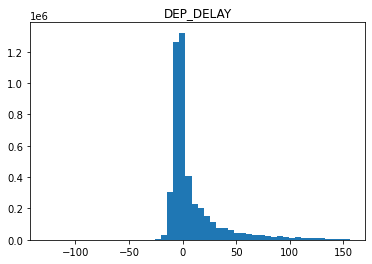

In [14]:
# flight_weather_df.hist(column='DEP_DELAY', bins =50, grid=False)

Most flights have none or minimal delays. So this distribution isn't surprising. The average flight is delayed by 9 minutes, with a fairly large standard deviation of 43 minutes. Looking at the 75th percentile, just 25% of flgiths had delays over 6 minutes.

Let's zoom in on those values.

In [19]:
# minimal = flight_weather_df.loc[flight_weather_df['DEP_DELAY'] < 15, 'DEP_DELAY']
# one_std = flight_weather_df.loc[flight_weather_df['DEP_DELAY'] < 45, 'DEP_DELAY']
# two_std = flight_weather_df.loc[flight_weather_df['DEP_DELAY'] < 90, 'DEP_DELAY']
# three_std = flight_weather_df.loc[flight_weather_df['DEP_DELAY'] < 10000, 'DEP_DELAY']

# print(minimal.count())
# print(one_std.count()- minimal.count())
# print(two_std.count()-one_std.count())
# print(three_std.count()-two_std.count())

3600057
606125
282266
135898


It looks like even when we look at the most extreme 25% of delays, the average delay here is still 48 minutes with a standard deviation of 76 minutes.  Over 75% of the data falls under a 13 minute delay.

We'll construct our buckets as such:

* Neglibile delay (No delay or 15 minutes or less)
* Mild (Delay between 15 and 30 minutes)
* Moderate (Delay between 30 minutes and hour)
* Serious (Delay over an hour)
* Major (Delay over 2 hours)

In [35]:
# Create a function to engineer this feature
def serious_delay(value):
    """
    Funtion takes in int or float and returns category of delay
    """
    if value <= 60:
        return "No"
    else:
        return "Yes"
    
flight_weather_df['delay_type'] = flight_weather_df['ARR_DELAY_NEW'].apply(serious_delay)

# Write the above DF to a CSV so we don't have to re-run all the code above
flight_weather_df.to_csv('data/weather_flight_modeling_data.csv', index=False)

In [18]:
flight_weather_df = pd.read_csv('data/weather_flight_modeling_data.csv')

In [20]:
flight_weather_df = flight_weather_df.groupby('DEST').filter(lambda x: len(x) > 10000)

In [24]:
flight_weather_sample = flight_weather_df.sample(frac=0.01, axis=0, random_state=123)
flight_weather_sample.to_csv('data/weather_flight_sample_data.csv', index=False)

In [2]:
flight_weather_df = pd.read_csv('data/weather_flight_sample_data.csv')

### Brining it all together

In [4]:
# Splitting features & target

y = flight_weather_df["delay_type"]
X = flight_weather_df.drop(["delay_type", "ARR_DELAY_NEW"], axis=1)

# Creating train, test and validation sets

X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [5]:
num_cols = ['AWND', 'PRCP', 'SNOW', 'TMAX', 'TMIN', 'da_AWND', 'da_PRCP', 'da_SNOW', 'da_TMAX',
            'da_TMIN', 'takeoff-time-minutes-from-midnight', 'ELEVATION', 'SNWD', 'WDF2', 'WSF2',
            'da_ELEVATION', 'da_SNWD', 'da_WDF2', 'da_WSF2', 'DISTANCE', 'avg_flights_last_3_hours',
            'avg_flights_last_1_hours', 'avg_flights_last_0_hours']

cat_cols = ['WT01', 'WT02', 'WT03', 'WT04', 'WT06', 'WT08', 'da_WT01', 'da_WT02', 'da_WT03', 'da_WT04', 'da_WT06','da_WT08',
           'DEST', 'OP_CARRIER', 'ORIGIN','MONTH', 'DAY_OF_WEEK', 'days-from-specific-holiday']

In [6]:
# Training Data

X_train_num = X_train[num_cols].copy()
X_train_cat = X_train[cat_cols].copy()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train_num.index, columns=X_train_num.columns)

X_train_cat = X_train_cat.applymap(str)
cols = X_train_cat.columns

X_train_ohe = pd.get_dummies(X_train_cat,prefix=cols, drop_first=False)

preprocessed_data = pd.concat([X_train_ohe, X_train_scaled], axis=1)

n_features = preprocessed_data.shape[1]

# Test Data

X_valid_num = X_valid[num_cols].copy()
X_valid_cat = X_valid[cat_cols].copy()

X_valid_scaled = scaler.transform(X_valid_num)
X_valid_scaled = pd.DataFrame(X_valid_scaled, index=X_valid_num.index, columns=X_valid_num.columns)

X_valid_cat = X_valid_cat.applymap(str)
cols = X_valid_cat.columns
X_valid_ohe = pd.get_dummies(X_valid_cat,prefix=cols, drop_first=False)

preprocessed_val_data = pd.concat([X_valid_ohe, X_valid_scaled], axis=1)

In [14]:
# Poly 2nd Degree Features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_num)
scaler_poly = StandardScaler()
X_train_poly_scaled = scaler_poly.fit_transform(X_train_poly)
X_train_poly_scaled = pd.DataFrame(X_train_poly_scaled, index=X_train_num.index, columns=poly.get_feature_names(X_train_num.columns))

preprocessed_poly2_data = pd.concat([X_train_ohe, X_train_poly_scaled], axis=1)

In [195]:
# Poly 3rd Degree Features
poly_3 = PolynomialFeatures(degree=3)
X_train_poly_3 = poly_3.fit_transform(X_train_num)
scaler_poly_3 = StandardScaler()
X_train_poly_3_scaled = scaler_poly_3.fit_transform(X_train_poly_3)
X_train_poly_3_scaled = pd.DataFrame(X_train_poly_3_scaled, index=X_train_num.index, columns=poly_3.get_feature_names(X_train_num.columns))

preprocessed_poly3_data = pd.concat([X_train_ohe, X_train_poly_3_scaled], axis=1)

In [196]:
n_features_poly = preprocessed_poly2_data.shape[1]
n_features_poly3 = preprocessed_poly3_data.shape[1]

In [42]:
# Poly validation Features
X_val_poly = poly.transform(X_valid_num)
X_val_poly_scaled = scaler_poly.transform(X_val_poly)
X_val_poly_scaled = pd.DataFrame(X_val_poly_scaled, index=X_valid_num.index, columns=poly.get_feature_names(X_valid_num.columns))

preprocessed_poly2_val_data = pd.concat([X_train_ohe, X_val_poly_scaled], axis=1)

In [197]:
# Poly3 validation Features
X_val_poly3 = poly_3.transform(X_valid_num)
X_val_poly3_scaled = scaler_poly_3.transform(X_val_poly3)
X_val_poly3_scaled = pd.DataFrame(X_val_poly3_scaled, index=X_valid_num.index, columns=poly_3.get_feature_names(X_valid_num.columns))

preprocessed_poly3_val_data = pd.concat([X_valid_ohe, X_val_poly3_scaled], axis=1)

In [7]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                   
                                    )
# class weights dict

class_weights_dict = dict(zip(np.unique(y_train), class_weights))

# Class weight num dict
class_weights_num_dict = {0: class_weights_dict['No'],
                1: class_weights_dict['Yes']}

# Sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
valid_sample_weights = compute_sample_weight(class_weight='balanced', y=y_valid)

# Labels for deep learning
binarizer = LabelBinarizer()
labels = binarizer.fit_transform(y_train)
valid_labels = binarizer.fit_transform(y_valid)

## Modeling

### Helper Functions

In [218]:
def visualize_training_results(hist):
   
    hist_dict = hist.history
    fig, ax = plt.subplots(figsize=(12, 8))

    loss_values = hist_dict['loss']
    val_loss_values = hist_dict['val_loss']

    epochs = range(1, len(loss_values) + 1)
    ax.plot(epochs, loss_values, label='Training loss')
    ax.plot(epochs, val_loss_values, label='Validation loss')

    ax.set_title('Training & validation loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend();
   
    fig, ax = plt.subplots(figsize=(12, 8))

    acc_values = hist_dict['acc']
    val_acc_values = hist_dict['val_acc']

    ax.plot(epochs, acc_values, label='Training acc')
    ax.plot(epochs, val_acc_values, label='Validation acc')
    ax.set_title('Training & validation accuracy')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.legend();
   
def evaluate_model(model, x, y):
    """
    Describe the function -- inputs, expected output, what is model? what are x/y and expected formats
    """
    y_true = y
    
    if type(y).__module__ == np.__name__:
        predications = model.predict(x)
        l = x.shape[0] 
        y_pred = np.zeros((l, 1))
        for i in range(predications.shape[0]):
            if predications[i,0] > 0.5: 
                y_pred[i, 0] = 1
            else:
                y_pred[i, 0] = 0
        
        print('Model Scores for Validation Data:')
        print('--------------')
        accuracy = accuracy_score(y_true, y_pred)
        print('Accuracy: %.3f' % round(accuracy, 3))
        # precision tp / (tp + fp)
        precision = precision_score(y_true, y_pred, pos_label=1)
        print('Precision: %.3f' % round(precision, 3))
        # recall: tp / (tp + fn)
        recall = recall_score(y_true, y_pred, pos_label=1)
        print('Recall: %.3f' % round(recall, 3))
        # f1: 2 tp / (2 tp + fp + fn)
        f1 = f1_score(y_true, y_pred, pos_label=1)
        print('F1 score: %.3f' % round(f1, 3))
        print('--------------')
        print('Confusion Matrix:')

        ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='true')
        
    else:
        y_pred  = model.predict(x)
   
        print('Model Scores for Validation Data:')
        print('--------------')
        accuracy = accuracy_score(y_true, y_pred)
        print('Accuracy: %.3f' % round(accuracy, 3))
        # precision tp / (tp + fp)
        precision = precision_score(y_true, y_pred, pos_label='Yes')
        print('Precision: %.3f' % round(precision, 3))
        # recall: tp / (tp + fn)
        recall = recall_score(y_true, y_pred, pos_label='Yes')
        print('Recall: %.3f' % round(recall, 3))
        # f1: 2 tp / (2 tp + fp + fn)
        f1 = f1_score(y_true, y_pred, pos_label='Yes')
        print('F1 score: %.3f' % round(f1, 3))
        print('--------------')
        print('Confusion Matrix:')

        ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='true')

### Gradient Descent

#### Logistic Regression

Model Scores for Validation Data:
--------------
Accuracy: 0.943
Precision: 0.000
Recall: 0.000
F1 score: 0.000
--------------
Confusion Matrix:


C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


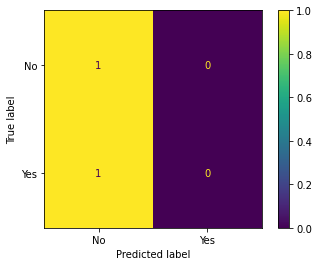

In [219]:
baselline_pipe = Pipeline(steps=[
    ('dc', DummyClassifier(strategy='most_frequent'))
])

baselline_pipe.fit(preprocessed_data, y_train)

evaluate_model(baselline_pipe, preprocessed_val_data, y_valid)

C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Scores for Validation Data:
--------------
Accuracy: 0.943
Precision: 0.512
Recall: 0.011
F1 score: 0.022
--------------
Confusion Matrix:


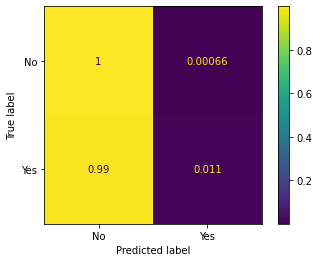

In [220]:
lr_pipe1 = Pipeline(steps=[
    ('lr', LogisticRegression(random_state=123))
])

lr_pipe1.fit(preprocessed_data, y_train)

evaluate_model(lr_pipe1, preprocessed_data, y_train)

C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Scores for Validation Data:
--------------
Accuracy: 0.942
Precision: 0.364
Recall: 0.012
F1 score: 0.022
--------------
Confusion Matrix:


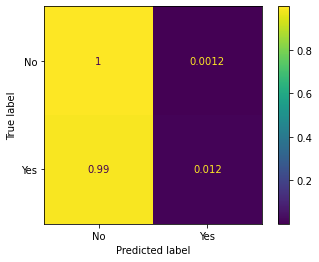

In [221]:
lr_pipe1_poly = Pipeline(steps=[
    ('lr', LogisticRegression(random_state=123))
])

lr_pipe1_poly.fit(preprocessed_poly2_data, y_train)

evaluate_model(lr_pipe1_poly, preprocessed_poly2_val_data, y_valid)

C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Scores for Validation Data:
--------------
Accuracy: 0.692
Precision: 0.116
Recall: 0.667
F1 score: 0.198
--------------
Confusion Matrix:


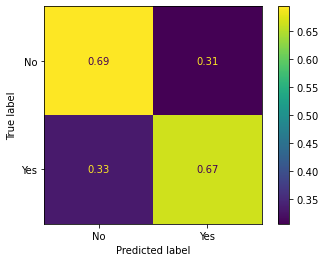

In [222]:
lr_pipe2 = Pipeline(steps=[
    ('lr', LogisticRegression(class_weight=class_weights_dict, random_state=123))
])

lr_pipe2.fit(preprocessed_data, y_train)

evaluate_model(lr_pipe2, preprocessed_data, y_train)

C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Scores for Validation Data:
--------------
Accuracy: 0.703
Precision: 0.115
Recall: 0.627
F1 score: 0.195
--------------
Confusion Matrix:


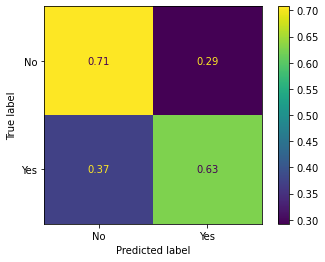

In [223]:
lr_pipe2_poly = Pipeline(steps=[
    ('lr', LogisticRegression(class_weight=class_weights_dict, random_state=123))
])

lr_pipe2_poly.fit(preprocessed_poly2_data, y_train)

evaluate_model(lr_pipe2_poly, preprocessed_poly2_val_data, y_valid)

#### Random Forest

Model Scores for Validation Data:
--------------
Accuracy: 0.943
Precision: 0.000
Recall: 0.000


C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.000
--------------
Confusion Matrix:


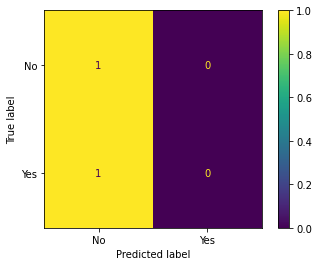

In [224]:
rf_pipe = Pipeline(steps=[
    ('rf', RandomForestClassifier(n_estimators=100,
                                  max_depth=12,
                                  random_state=123))
])

rf_pipe.fit(preprocessed_data, y_train)

evaluate_model(rf_pipe, preprocessed_val_data, y_valid)

Model Scores for Validation Data:
--------------
Accuracy: 0.853
Precision: 0.159
Recall: 0.366
F1 score: 0.222
--------------
Confusion Matrix:


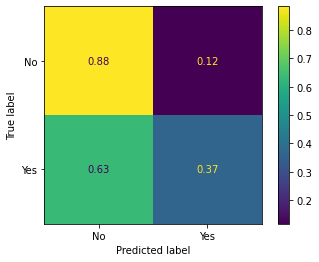

In [225]:
rf_pipe2 = Pipeline(steps=[
    ('rf', RandomForestClassifier(n_estimators=100,
                                  max_depth=12,
                                  class_weight=class_weights_dict,
                                  random_state=123))
])

rf_pipe2.fit(preprocessed_data, y_train)

evaluate_model(rf_pipe2, preprocessed_val_data, y_valid)

Model Scores for Validation Data:
--------------
Accuracy: 0.900
Precision: 0.189
Recall: 0.229
F1 score: 0.207
--------------
Confusion Matrix:


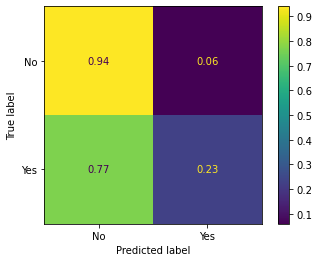

In [226]:
rf_pipe_poly = Pipeline(steps=[
    ('rf', RandomForestClassifier(n_estimators=100,
                                  max_depth=12,
                                  class_weight=class_weights_dict,
                                  random_state=123))
])

rf_pipe_poly.fit(preprocessed_poly2_data, y_train)

evaluate_model(rf_pipe_poly, preprocessed_poly2_val_data, y_valid)

#### XGBoost

Model Scores for Validation Data:
--------------
Accuracy: 0.795
Precision: 0.138
Recall: 0.494
F1 score: 0.216
--------------
Confusion Matrix:


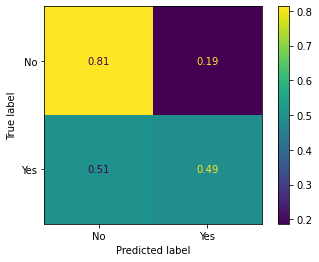

In [227]:
xgb_pipe = Pipeline([
    ('my_xgb_clf', xgb.XGBClassifier()),
])

xgb_pipe.fit(preprocessed_data, y_train, my_xgb_clf__sample_weight=sample_weights)

evaluate_model(xgb_pipe, preprocessed_val_data, y_valid)

Model Scores for Validation Data:
--------------
Accuracy: 0.942
Precision: 0.333
Recall: 0.022
F1 score: 0.041
--------------
Confusion Matrix:


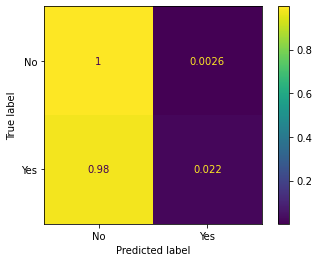

In [228]:
xgb_pipe1 = Pipeline([
    ('my_xgb_clf', xgb.XGBClassifier()),
])

xgb_pipe1.fit(preprocessed_data, y_train)

evaluate_model(xgb_pipe1, preprocessed_val_data, y_valid)

Model Scores for Validation Data:
--------------
Accuracy: 0.754
Precision: 0.123
Recall: 0.537
F1 score: 0.200
--------------
Confusion Matrix:


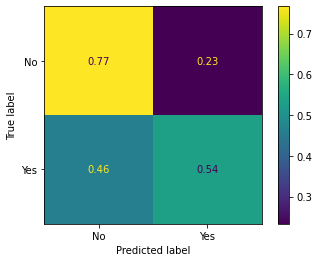

In [229]:
xgb_pipe2 = Pipeline([
    ('my_xgb_clf', xgb.XGBClassifier(subsample=0.4, max_depth=15, alpha = 100))
])

xgb_pipe2.fit(preprocessed_data,
              y_train,
              my_xgb_clf__sample_weight=sample_weights)

evaluate_model(xgb_pipe2, preprocessed_val_data, y_valid)

In [230]:
from collections import Counter
counter = Counter(y_train)
estimate = counter['No'] / counter['Yes']

16.568120137506785

Model Scores for Validation Data:
--------------
Accuracy: 0.794
Precision: 0.134
Recall: 0.474
F1 score: 0.209
--------------
Confusion Matrix:


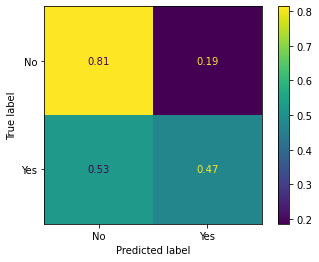

In [231]:
xgb_scaled_model = XGBClassifier(scale_pos_weight=estimate)
xgb_scaled_model.fit(preprocessed_data, y_train)

evaluate_model(xgb_scaled_model, preprocessed_val_data, y_valid)

Model Scores for Validation Data:
--------------
Accuracy: 0.740
Precision: 0.129
Recall: 0.615
F1 score: 0.213
--------------
Confusion Matrix:


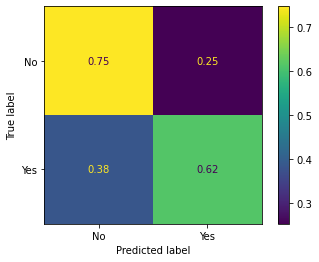

In [243]:
xgb_scaled_model2 = XGBClassifier(scale_pos_weight=estimate,
                                  max_depth = 4,
                                  eta = 0.2,
                                  nthread = 2,
                                  colsample_bytree = 0.7,
                                  gamma = 2.5,
                                  objective = "binary:logistic")

xgb_scaled_model2.fit(preprocessed_data, y_train, eval_metric=f1_score)

evaluate_model(xgb_scaled_model2, preprocessed_val_data, y_valid)

Model Scores for Validation Data:
--------------
Accuracy: 0.764
Precision: 0.134
Recall: 0.572
F1 score: 0.217
--------------
Confusion Matrix:


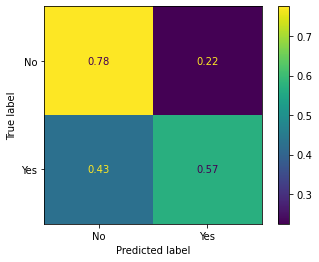

In [248]:
xgb_scaled_model3 = XGBClassifier(scale_pos_weight=estimate,
                                  max_depth = 6,
                                  eta = 0.1,
                                  nthread = 2,
                                  colsample_bytree = 0.7,
                                  gamma = 2.5,
                                  objective = "binary:logistic")

xgb_scaled_model3.fit(preprocessed_data, y_train, eval_metric=f1_score)

evaluate_model(xgb_scaled_model3, preprocessed_val_data, y_valid)

### LightGBM

Model Scores for Validation Data:
--------------
Accuracy: 0.942
Precision: 0.357
Recall: 0.007
F1 score: 0.014
--------------
Confusion Matrix:


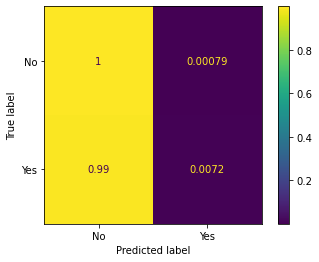

In [251]:
lgbm_model_1 = LGBMClassifier()

lgbm_model_1.fit(preprocessed_data, y_train)

evaluate_model(lgbm_model_1, preprocessed_val_data, y_valid)

Model Scores for Validation Data:
--------------
Accuracy: 0.797
Precision: 0.149
Recall: 0.540
F1 score: 0.234
--------------
Confusion Matrix:


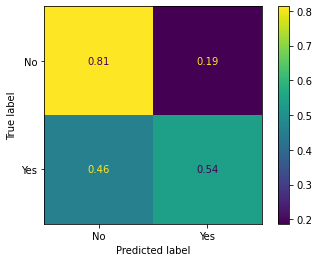

In [308]:
lgbm_model_2 = LGBMClassifier(scale_pos_weight=13,
                              learning_rate = 0.1,
                              num_leaves = 7,
                              max_depth = 3,
                              min_child_samples = 100,
                              max_bin = 100,
                              subsample = 0.7,
                              subsample_freq = 2,
                              colsample_bytree = 0.9,
                              min_child_weight = 0)

lgbm_model_2.fit(preprocessed_data, y_train)

evaluate_model(lgbm_model_2, preprocessed_val_data, y_valid)

Model Scores for Validation Data:
--------------
Accuracy: 0.795
Precision: 0.146
Recall: 0.533
F1 score: 0.229
--------------
Confusion Matrix:


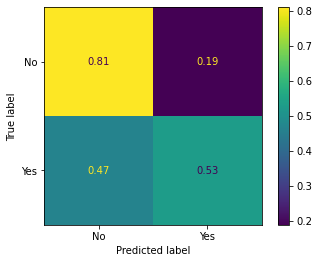

In [293]:
lgbm_model_3 = LGBMClassifier(scale_pos_weight=13,
                              learning_rate = 0.10,
                              num_leaves = 7,
                              max_depth = 3,
                              min_child_samples = 100,
                              max_bin = 100,
                              subsample = 0.9,
                              subsample_freq = 1,
                              colsample_bytree = 0.9,
                              min_child_weight = 0)

lgbm_model_3.fit(preprocessed_poly2_data, y_train)

evaluate_model(lgbm_model_3, preprocessed_poly2_val_data, y_valid)

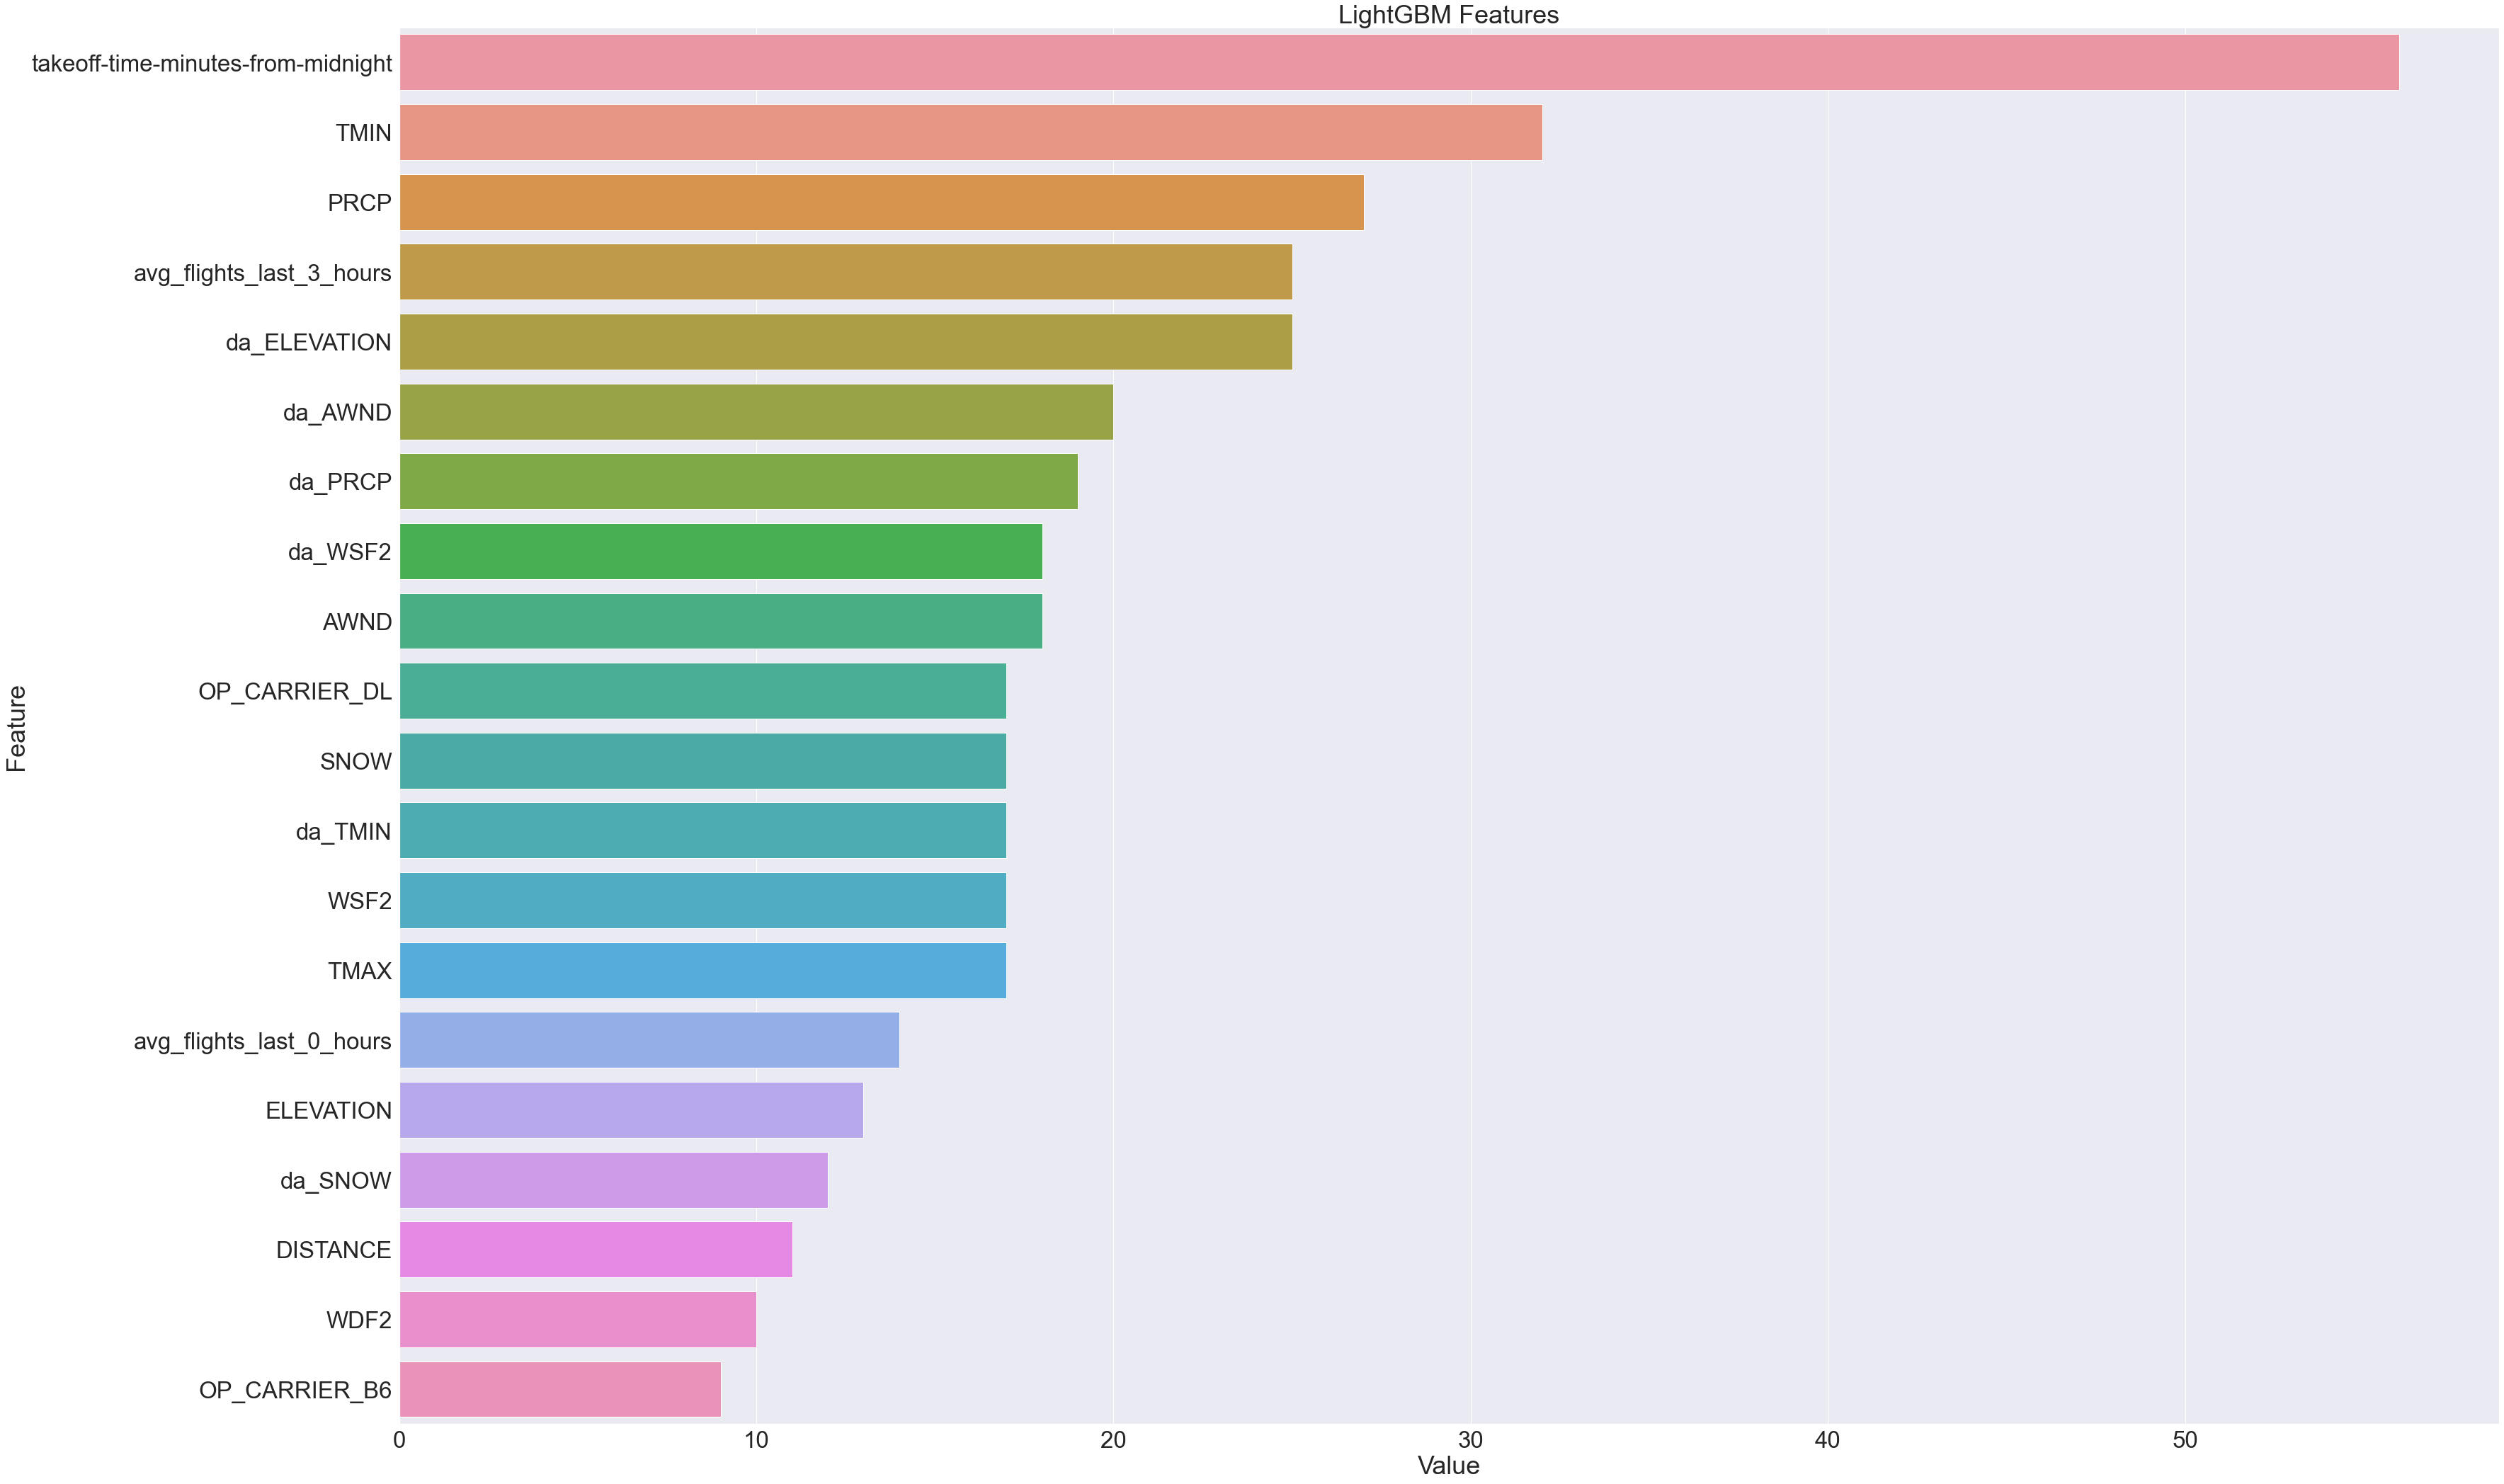

In [330]:
def plotImp(model, X , num = 20, fig_size = (50, 30)):
    boost = model.booster_
    feature_imp = pd.DataFrame({'Value':boost.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 3)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.show()
    
plotImp(lgbm_model_2, preprocessed_data)

### Deep Learning Models

In [153]:
dl_model_1 = Sequential()
dl_model_1.add(Dense(300, activation='relu', input_dim=n_features))
dl_model_1.add(Dense(150, activation='relu'))
dl_model_1.add(Dense(75, activation='relu'))
dl_model_1.add(Dense(30, activation='relu'))
dl_model_1.add(Dense(15, activation='relu'))
dl_model_1.add(Dense(1, activation='sigmoid'))

dl_model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

dl_model_1_results = dl_model_1.fit(preprocessed_data,
                                    labels,
                                    class_weight=class_weights_num_dict,
                                    epochs=25,
                                    batch_size=32,
                                    validation_split=0.2)

Epoch 1/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.6235 - acc: 0.6984 - val_loss: 0.6083 - val_acc: 0.6646
Epoch 2/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.5953 - acc: 0.7124 - val_loss: 0.5319 - val_acc: 0.7584
Epoch 3/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.5783 - acc: 0.6920 - val_loss: 0.6787 - val_acc: 0.6722
Epoch 4/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.5481 - acc: 0.7247 - val_loss: 0.5842 - val_acc: 0.7160
Epoch 5/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.5052 - acc: 0.7263 - val_loss: 0.5990 - val_acc: 0.6993
Epoch 6/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.4506 - acc: 0.7562 - val_loss: 0.6148 - val_acc: 0.6615
Epoch 7/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.3958 - acc: 0.7807 - val_loss: 0.5291 - val_acc: 0.7420
Epoch 8/25
2428/2428 [==============================] - 4s 2ms

380/380 [==============================] - 0s 1ms/step
Model Scores for Validation Data:
--------------
Accuracy: 0.868
Precision: 0.144
Recall: 0.264
F1 score: 0.186
--------------
Confusion Matrix:


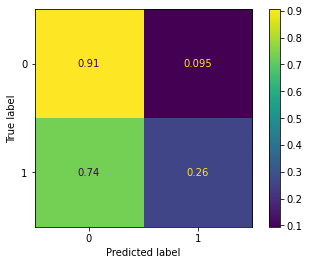

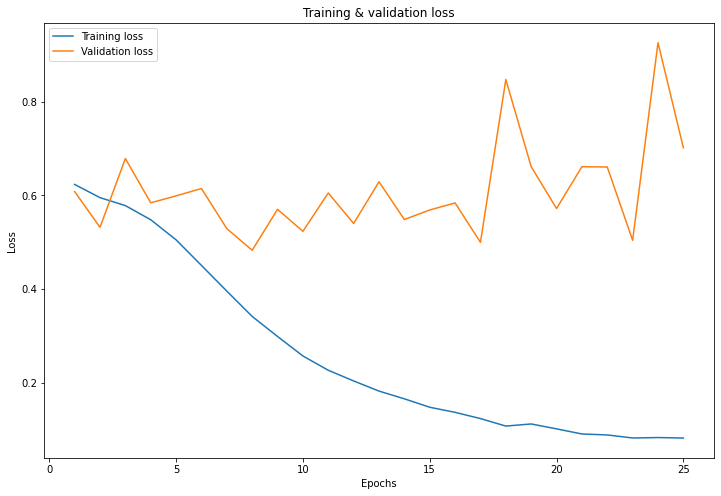

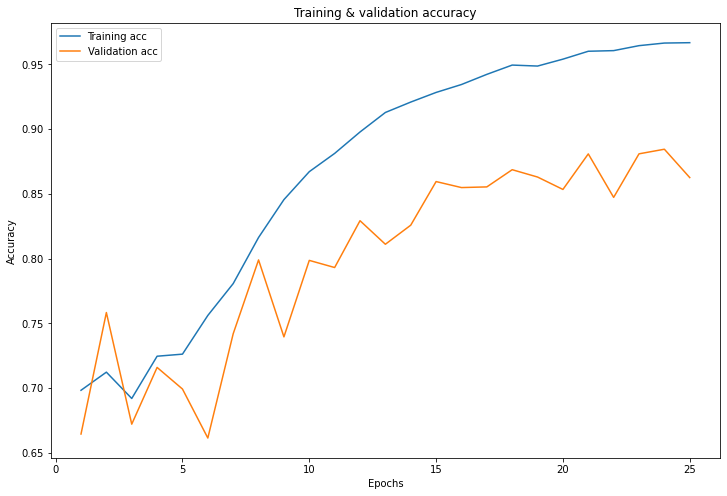

In [311]:
# Evaluate Results
evaluate_model(dl_model_1, preprocessed_val_data, valid_labels)
visualize_training_results(dl_model_1_results)

In [171]:
dl_model_1_poly = Sequential()
dl_model_1_poly.add(Dense(300, activation='relu', input_dim=n_features_poly))
dl_model_1_poly.add(Dense(150, activation='relu'))
dl_model_1_poly.add(Dense(75, activation='relu'))
dl_model_1_poly.add(Dense(30, activation='relu'))
dl_model_1_poly.add(Dense(15, activation='relu'))
dl_model_1_poly.add(Dense(1, activation='sigmoid'))

dl_model_1_poly.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

dl_model_1_poly_results = dl_model_1_poly.fit(preprocessed_poly2_data,
                                    labels,
                                    class_weight=class_weights_num_dict,
                                    epochs=50,
                                    batch_size=32,
                                    validation_split=0.2)

Epoch 1/50
2428/2428 [==============================] - 8s 3ms/step - loss: 0.6335 - acc: 0.6623 - val_loss: 0.5814 - val_acc: 0.6650
Epoch 2/50
2428/2428 [==============================] - 6s 3ms/step - loss: 0.6174 - acc: 0.6741 - val_loss: 0.6444 - val_acc: 0.7016
Epoch 3/50
2428/2428 [==============================] - 7s 3ms/step - loss: 0.6019 - acc: 0.6971 - val_loss: 0.5936 - val_acc: 0.6764
Epoch 4/50
2428/2428 [==============================] - 7s 3ms/step - loss: 0.5942 - acc: 0.6957 - val_loss: 0.6409 - val_acc: 0.6746
Epoch 5/50
2428/2428 [==============================] - 7s 3ms/step - loss: 0.5838 - acc: 0.6993 - val_loss: 0.6618 - val_acc: 0.5864
Epoch 6/50
2428/2428 [==============================] - 7s 3ms/step - loss: 0.5760 - acc: 0.7005 - val_loss: 0.6383 - val_acc: 0.6715
Epoch 7/50
2428/2428 [==============================] - 7s 3ms/step - loss: 0.5708 - acc: 0.7060 - val_loss: 0.5445 - val_acc: 0.7240
Epoch 8/50
2428/2428 [==============================] - 6s 3ms

380/380 [==============================] - 1s 2ms/step
Model Scores for Validation Data:
--------------
Accuracy: 0.883
Precision: 0.143
Recall: 0.212
F1 score: 0.171
--------------
Confusion Matrix:


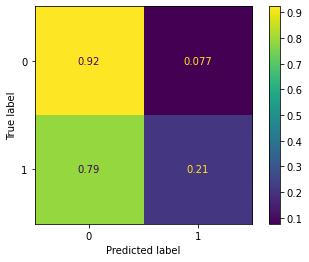

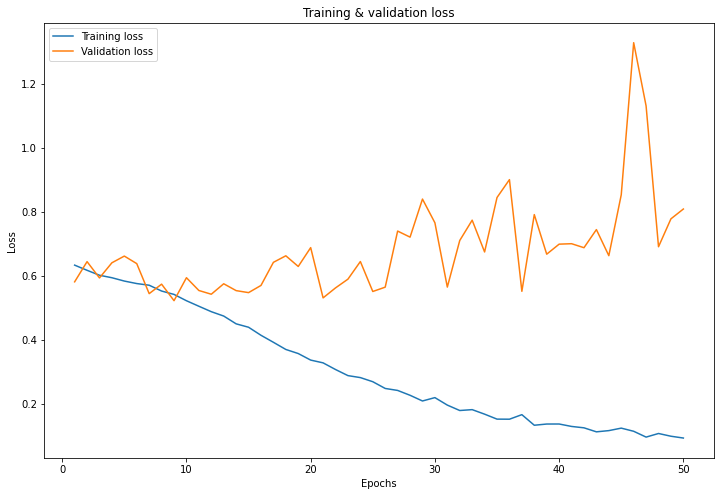

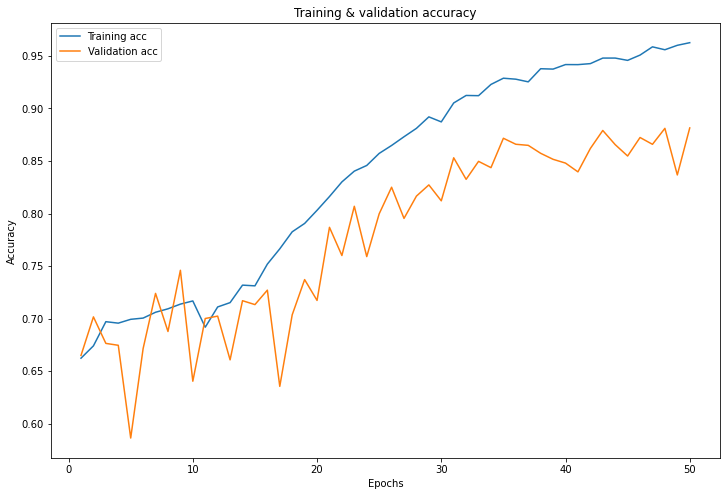

In [312]:
# Evaluate Results
evaluate_model(dl_model_1_poly, preprocessed_poly2_val_data, valid_labels)
visualize_training_results(dl_model_1_poly_results)

In [155]:
dl_model_2 = Sequential()
dl_model_2.add(Dense(300, kernel_initializer='he_normal',
                     kernel_regularizer=regularizers.l2(0.001),
                     activation='relu',
                     input_shape=(n_features,)))
dl_model_2.add(Dense(150, activation='relu'))
dl_model_2.add(Dense(75, activation='relu'))
dl_model_2.add(Dense(30, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
dl_model_2.add(Dense(15, activation='relu'))
dl_model_2.add(Dense(1, activation='sigmoid'))

dl_model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

dl_model_2_results = dl_model_2.fit(preprocessed_data,
                           labels,
                           class_weight=class_weights_num_dict,
                           epochs=25,
                           batch_size=32,
                           validation_split=0.2)

Epoch 1/25
2428/2428 [==============================] - 6s 2ms/step - loss: 0.6894 - acc: 0.6916 - val_loss: 0.6831 - val_acc: 0.6039
Epoch 2/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.6327 - acc: 0.6999 - val_loss: 0.6490 - val_acc: 0.6772
Epoch 3/25
2428/2428 [==============================] - 6s 2ms/step - loss: 0.6253 - acc: 0.7035 - val_loss: 0.7051 - val_acc: 0.6093
Epoch 4/25
2428/2428 [==============================] - 6s 2ms/step - loss: 0.6183 - acc: 0.7031 - val_loss: 0.6793 - val_acc: 0.6714
Epoch 5/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.6149 - acc: 0.7166 - val_loss: 0.6100 - val_acc: 0.7405
Epoch 6/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.6114 - acc: 0.7237 - val_loss: 0.6378 - val_acc: 0.7014
Epoch 7/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.6105 - acc: 0.7210 - val_loss: 0.5521 - val_acc: 0.7242
Epoch 8/25
2428/2428 [==============================] - 5s 2ms

380/380 [==============================] - 0s 1ms/step
Model Scores for Validation Data:
--------------
Accuracy: 0.723
Precision: 0.101
Recall: 0.486
F1 score: 0.167
--------------
Confusion Matrix:


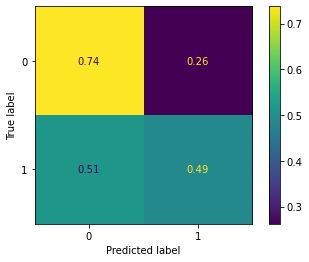

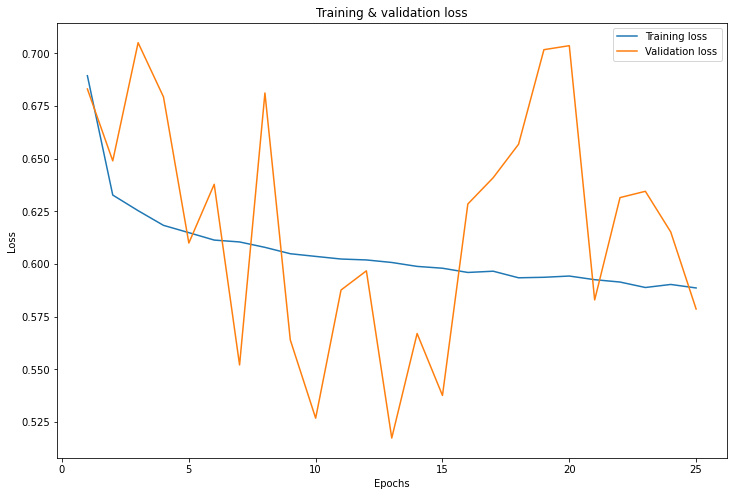

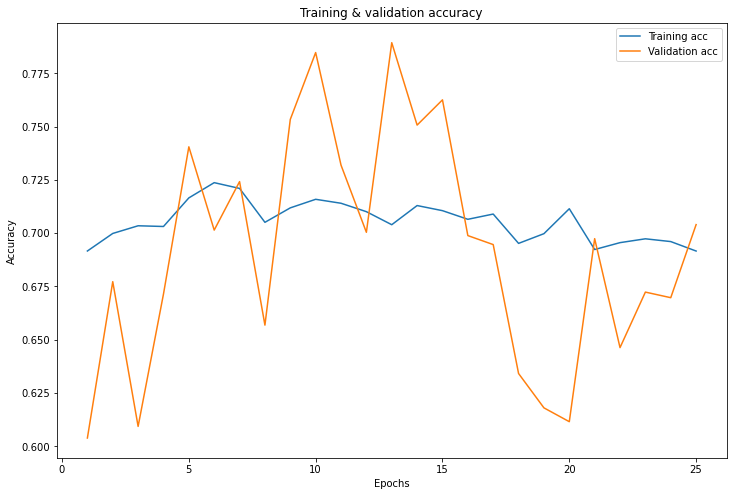

In [313]:
# Evaluate Results
evaluate_model(dl_model_2, preprocessed_val_data, valid_labels)
visualize_training_results(dl_model_2_results)

In [206]:
dl_model_3 = Sequential()
dl_model_3.add(Dense(300, kernel_initializer='he_normal',
                     kernel_regularizer=regularizers.l2(0.001),
                     activation='relu',
                     input_shape=(n_features,)))
dl_model_3.add(Dense(150, activation='relu'))
dl_model_3.add(Dense(75, activation='relu'))
dl_model_3.add(Dense(30, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
dl_model_3.add(Dense(15, activation='relu'))
dl_model_3.add(Dense(1, activation='sigmoid'))

dl_model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

dl_model_3_results = dl_model_2.fit(preprocessed_data,
                           labels,
                           class_weight=class_weights_num_dict,
                           epochs=100,
                           batch_size=100,
                           validation_split=0.2)

Epoch 1/100
777/777 [==============================] - 3s 3ms/step - loss: 0.5617 - acc: 0.7078 - val_loss: 0.6077 - val_acc: 0.6797
Epoch 2/100
777/777 [==============================] - 2s 3ms/step - loss: 0.5560 - acc: 0.6976 - val_loss: 0.5948 - val_acc: 0.6942
Epoch 3/100
777/777 [==============================] - 2s 3ms/step - loss: 0.5530 - acc: 0.6952 - val_loss: 0.6282 - val_acc: 0.6599
Epoch 4/100
777/777 [==============================] - 3s 3ms/step - loss: 0.5490 - acc: 0.6897 - val_loss: 0.6134 - val_acc: 0.6612
Epoch 5/100
777/777 [==============================] - 3s 3ms/step - loss: 0.5467 - acc: 0.6850 - val_loss: 0.6135 - val_acc: 0.6730
Epoch 6/100
777/777 [==============================] - 3s 3ms/step - loss: 0.5446 - acc: 0.6875 - val_loss: 0.6310 - val_acc: 0.6323
Epoch 7/100
777/777 [==============================] - 3s 3ms/step - loss: 0.5423 - acc: 0.6840 - val_loss: 0.6065 - val_acc: 0.6424
Epoch 8/100
777/777 [==============================] - 3s 3ms/step - 

777/777 [==============================] - 2s 3ms/step - loss: 0.4653 - acc: 0.7548 - val_loss: 0.6626 - val_acc: 0.6922
Epoch 63/100
777/777 [==============================] - 2s 3ms/step - loss: 0.4564 - acc: 0.7614 - val_loss: 0.5877 - val_acc: 0.7524
Epoch 64/100
777/777 [==============================] - 2s 3ms/step - loss: 0.4605 - acc: 0.7567 - val_loss: 0.6771 - val_acc: 0.6704
Epoch 65/100
777/777 [==============================] - 2s 3ms/step - loss: 0.4570 - acc: 0.7575 - val_loss: 0.6332 - val_acc: 0.7153
Epoch 66/100
777/777 [==============================] - 2s 3ms/step - loss: 0.4607 - acc: 0.7599 - val_loss: 0.6723 - val_acc: 0.6839
Epoch 67/100
777/777 [==============================] - 2s 3ms/step - loss: 0.4553 - acc: 0.7624 - val_loss: 0.6970 - val_acc: 0.6771
Epoch 68/100
777/777 [==============================] - 3s 3ms/step - loss: 0.4553 - acc: 0.7629 - val_loss: 0.6419 - val_acc: 0.7136
Epoch 69/100
777/777 [==============================] - 3s 3ms/step - loss:

380/380 [==============================] - 1s 1ms/step
Model Scores for Validation Data:
--------------
Accuracy: 0.101
Precision: 0.056
Recall: 0.925
F1 score: 0.105
--------------
Confusion Matrix:


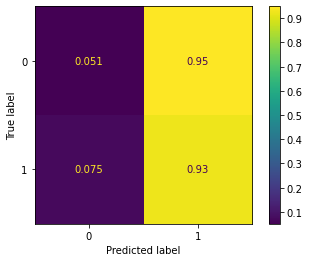

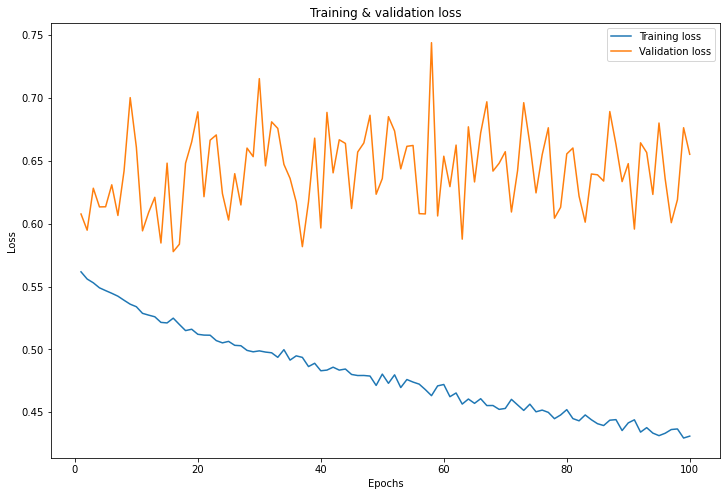

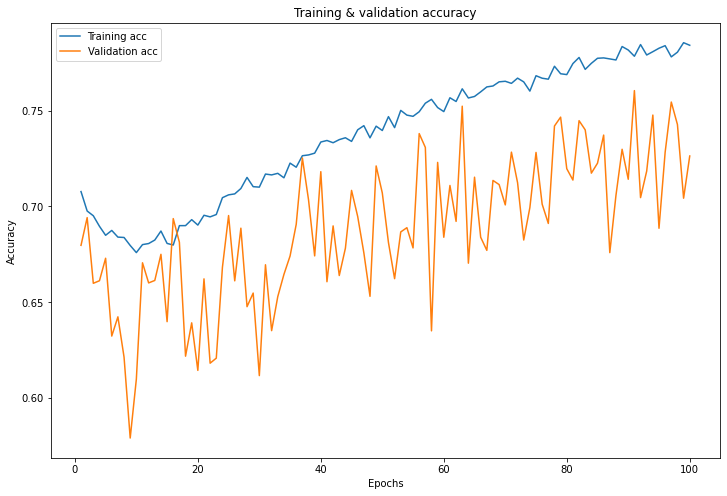

In [314]:
# Evaluate Results
evaluate_model(dl_model_3, preprocessed_val_data, valid_labels)
visualize_training_results(dl_model_3_results)

In [175]:
dl_model_1_poly_2 = Sequential()
dl_model_1_poly_2.add(Dense(300, activation='relu', input_dim=n_features_poly))
dl_model_1_poly_2.add(Dense(150, activation='relu'))
dl_model_1_poly_2.add(Dense(75, activation='relu'))
dl_model_1_poly_2.add(Dense(30, activation='relu'))
dl_model_1_poly_2.add(Dense(15, activation='relu'))
dl_model_1_poly_2.add(Dense(1, activation='sigmoid'))

dl_model_1_poly_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

dl_model_1_poly_2_results = dl_model_1_poly_2.fit(preprocessed_poly2_data,
                                    labels,
                                    class_weight=class_weights_num_dict,
                                    epochs=100,
                                    batch_size=32,
                                    validation_split=0.2)

Epoch 1/100
2428/2428 [==============================] - 8s 3ms/step - loss: 0.6391 - acc: 0.6488 - val_loss: 0.6745 - val_acc: 0.6418
Epoch 2/100
2428/2428 [==============================] - 7s 3ms/step - loss: 0.6177 - acc: 0.6784 - val_loss: 0.6295 - val_acc: 0.6760
Epoch 3/100
2428/2428 [==============================] - 6s 3ms/step - loss: 0.6036 - acc: 0.6890 - val_loss: 0.6816 - val_acc: 0.6552
Epoch 4/100
2428/2428 [==============================] - 6s 3ms/step - loss: 0.5950 - acc: 0.6759 - val_loss: 0.5557 - val_acc: 0.6124
Epoch 5/100
2428/2428 [==============================] - 6s 3ms/step - loss: 0.5895 - acc: 0.6895 - val_loss: 0.6212 - val_acc: 0.6540
Epoch 6/100
2428/2428 [==============================] - 6s 3ms/step - loss: 0.5768 - acc: 0.6908 - val_loss: 0.5617 - val_acc: 0.7153
Epoch 7/100
2428/2428 [==============================] - 6s 3ms/step - loss: 0.5678 - acc: 0.6949 - val_loss: 0.6035 - val_acc: 0.6932
Epoch 8/100
2428/2428 [==============================] 

2428/2428 [==============================] - 6s 2ms/step - loss: 0.0915 - acc: 0.9604 - val_loss: 7.1141 - val_acc: 0.8244
Epoch 62/100
2428/2428 [==============================] - 6s 2ms/step - loss: 0.2222 - acc: 0.9448 - val_loss: 0.8899 - val_acc: 0.8750
Epoch 63/100
2428/2428 [==============================] - 7s 3ms/step - loss: 0.1022 - acc: 0.9600 - val_loss: 0.9520 - val_acc: 0.8636
Epoch 64/100
2428/2428 [==============================] - 6s 2ms/step - loss: 0.0814 - acc: 0.9646 - val_loss: 1.1982 - val_acc: 0.8750
Epoch 65/100
2428/2428 [==============================] - 6s 3ms/step - loss: 0.0848 - acc: 0.9615 - val_loss: 1.4895 - val_acc: 0.8560
Epoch 66/100
2428/2428 [==============================] - 6s 2ms/step - loss: 0.0901 - acc: 0.9600 - val_loss: 1.1219 - val_acc: 0.8411
Epoch 67/100
2428/2428 [==============================] - 6s 2ms/step - loss: 0.0938 - acc: 0.9582 - val_loss: 1.5891 - val_acc: 0.8773
Epoch 68/100
2428/2428 [==============================] - 6s 

380/380 [==============================] - 1s 2ms/step
Model Scores for Validation Data:
--------------
Accuracy: 0.883
Precision: 0.124
Recall: 0.171
F1 score: 0.144
--------------
Confusion Matrix:


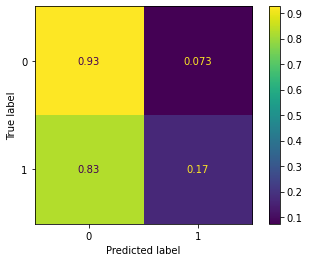

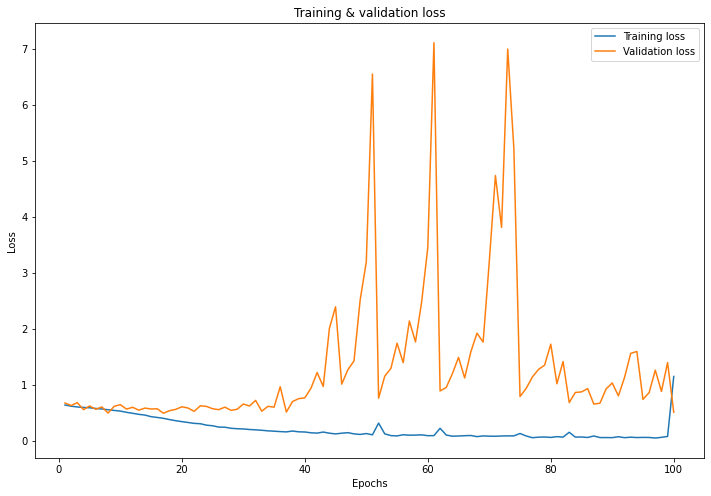

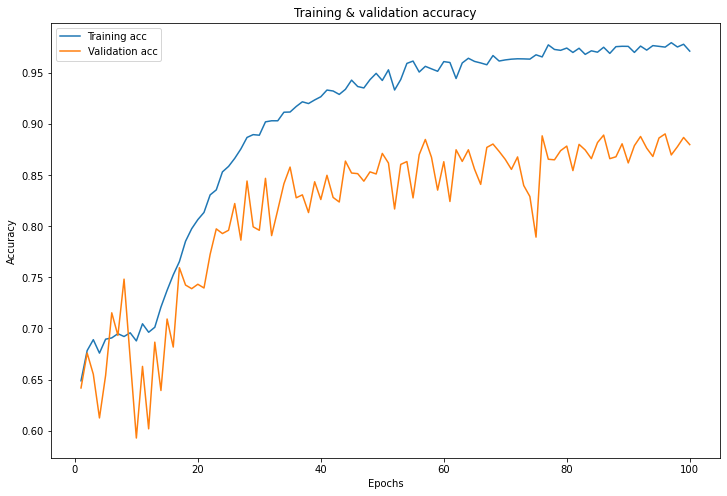

In [315]:
# Evaluate Results
evaluate_model(dl_model_1_poly_2, preprocessed_poly2_val_data, valid_labels)
visualize_training_results(dl_model_1_poly_2_results)

In [178]:
dl_model_1_poly_2_reg = Sequential()
dl_model_1_poly_2_reg.add(Dense(300, activation='relu', input_dim=n_features_poly))
dl_model_1_poly_2_reg.add(layers.Dropout(0.3))
dl_model_1_poly_2_reg.add(Dense(150, activation='relu'))
dl_model_1_poly_2_reg.add(Dense(75, activation='relu'))
dl_model_1_poly_2_reg.add(Dense(30, activation='relu'))
dl_model_1_poly_2_reg.add(layers.Dropout(0.3))
dl_model_1_poly_2_reg.add(Dense(15, activation='relu'))
dl_model_1_poly_2_reg.add(Dense(1, activation='sigmoid'))

dl_model_1_poly_2_reg.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

dl_model_1_poly_2_reg_results = dl_model_1_poly_2_reg.fit(preprocessed_poly2_data,
                                    labels,
                                    class_weight=class_weights_num_dict,
                                    epochs=100,
                                    batch_size=32,
                                    validation_split=0.2)

Epoch 1/100
2428/2428 [==============================] - 8s 3ms/step - loss: 0.6501 - acc: 0.6505 - val_loss: 0.5360 - val_acc: 0.8054
Epoch 2/100
2428/2428 [==============================] - 7s 3ms/step - loss: 0.6301 - acc: 0.6979 - val_loss: 0.6074 - val_acc: 0.6998
Epoch 3/100
2428/2428 [==============================] - 7s 3ms/step - loss: 0.6205 - acc: 0.6994 - val_loss: 0.6233 - val_acc: 0.6852
Epoch 4/100
2428/2428 [==============================] - 7s 3ms/step - loss: 0.6120 - acc: 0.6962 - val_loss: 0.5841 - val_acc: 0.7371
Epoch 5/100
2428/2428 [==============================] - 7s 3ms/step - loss: 0.6082 - acc: 0.6927 - val_loss: 0.5063 - val_acc: 0.7646
Epoch 6/100
2428/2428 [==============================] - 7s 3ms/step - loss: 0.6054 - acc: 0.6878 - val_loss: 0.5105 - val_acc: 0.8449
Epoch 7/100
2428/2428 [==============================] - 7s 3ms/step - loss: 0.6024 - acc: 0.6800 - val_loss: 0.5685 - val_acc: 0.6912
Epoch 8/100
2428/2428 [==============================] 

2428/2428 [==============================] - 8s 3ms/step - loss: 0.3223 - acc: 0.8426 - val_loss: 0.3517 - val_acc: 0.8599
Epoch 62/100
2428/2428 [==============================] - 8s 3ms/step - loss: 0.3176 - acc: 0.8466 - val_loss: 0.3644 - val_acc: 0.8832
Epoch 63/100
2428/2428 [==============================] - 8s 3ms/step - loss: 0.3231 - acc: 0.8467 - val_loss: 0.3885 - val_acc: 0.8456
Epoch 64/100
2428/2428 [==============================] - 7s 3ms/step - loss: 0.3147 - acc: 0.8493 - val_loss: 0.3577 - val_acc: 0.8735
Epoch 65/100
2428/2428 [==============================] - 7s 3ms/step - loss: 0.3076 - acc: 0.8568 - val_loss: 0.3903 - val_acc: 0.8658
Epoch 66/100
2428/2428 [==============================] - 7s 3ms/step - loss: 0.3175 - acc: 0.8582 - val_loss: 0.2890 - val_acc: 0.9045
Epoch 67/100
2428/2428 [==============================] - 8s 3ms/step - loss: 0.3029 - acc: 0.8599 - val_loss: 0.3994 - val_acc: 0.8407
Epoch 68/100
2428/2428 [==============================] - 8s 

380/380 [==============================] - 1s 2ms/step
Model Scores for Validation Data:
--------------
Accuracy: 0.875
Precision: 0.147
Recall: 0.248
F1 score: 0.185
--------------
Confusion Matrix:


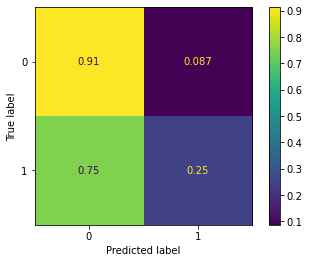

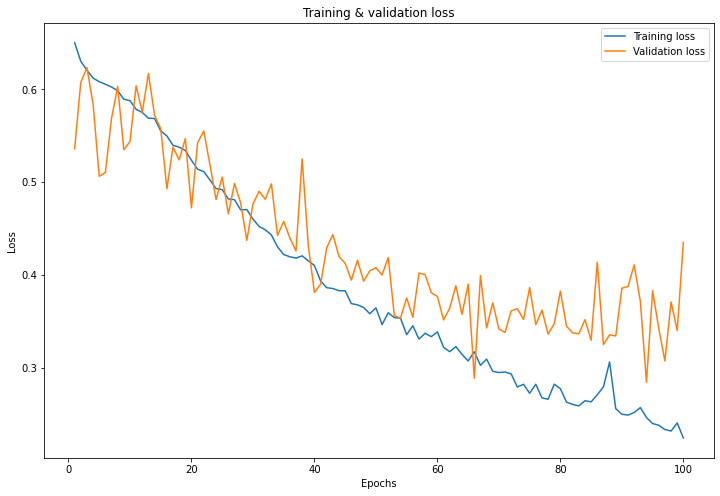

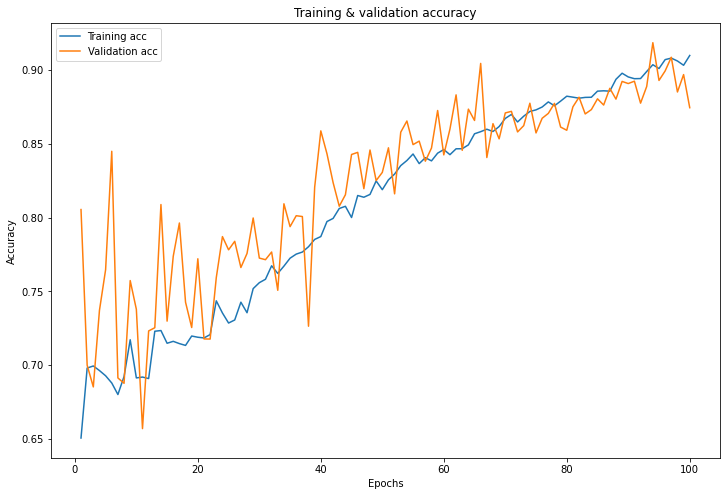

In [316]:
evaluate_model(dl_model_1_poly_2_reg, preprocessed_poly2_val_data, valid_labels)
visualize_training_results(dl_model_1_poly_2_reg_results)

380/380 [==============================] - 1s 2ms/step


Text(0, 0.5, 'Number of Predictions')

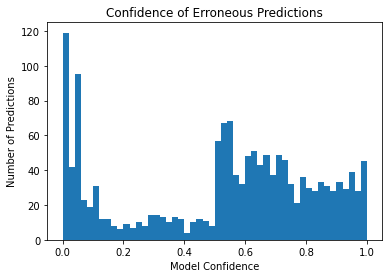

In [318]:
preds = dl_model_1_poly_2_reg.predict(preprocessed_poly2_val_data)
preds_int = np.zeros((preprocessed_poly2_val_data.shape[0] , 1))
for i in range(preds_int.shape[0]):
    if preds[i,0] > 0.5: 
        preds_int[i, 0] = 1
    else:
        preds_int[i, 0] = 0

wrong_predictions = []

for i in range(preds.shape[0]):
    if preds_int[i, 0] == valid_labels[i,0]: 
        pass
    else:
        wrong_predictions.append(preds[i,0])

# matplotlib histogram
plt.hist(wrong_predictions, bins = 50)
plt.title('Confidence of Erroneous Predictions')
plt.xlabel('Model Confidence')
plt.ylabel('Number of Predictions')

Looks like the model pretty uniformly struggles with predicting positive cases, and there is a big number instances (200+) where the model is almost confident there will be no delay and there is.

In [204]:
dl_model_1_poly_3 = Sequential()
dl_model_1_poly_3.add(Dense(2900, activation='relu', input_dim=n_features_poly3))
dl_model_1_poly_3.add(Dense(1500, activation='relu'))
dl_model_1_poly_3.add(Dense(750, activation='relu'))
dl_model_1_poly_3.add(Dense(250, activation='relu'))
dl_model_1_poly_3.add(Dense(100, activation='relu'))
dl_model_1_poly_3.add(Dense(50, activation='relu'))
dl_model_1_poly_3.add(Dense(1, activation='sigmoid'))

dl_model_1_poly_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

dl_model_1_poly_3_results = dl_model_1_poly_3.fit(preprocessed_poly3_data,
                                    labels,
                                    class_weight=class_weights_num_dict,
                                    epochs=100,
                                    batch_size=1000,
                                    validation_split=0.2)

Epoch 1/100
78/78 [==============================] - 15s 186ms/step - loss: 0.6771 - acc: 0.6536 - val_loss: 0.6478 - val_acc: 0.6807
Epoch 2/100
78/78 [==============================] - 11s 147ms/step - loss: 0.6234 - acc: 0.6882 - val_loss: 0.7430 - val_acc: 0.5528
Epoch 3/100
78/78 [==============================] - 13s 164ms/step - loss: 0.6184 - acc: 0.6754 - val_loss: 0.5305 - val_acc: 0.7515
Epoch 4/100
78/78 [==============================] - 12s 159ms/step - loss: 0.6099 - acc: 0.6819 - val_loss: 0.6014 - val_acc: 0.6494
Epoch 5/100
78/78 [==============================] - 13s 162ms/step - loss: 0.6051 - acc: 0.6958 - val_loss: 0.5780 - val_acc: 0.6919
Epoch 6/100
78/78 [==============================] - 13s 163ms/step - loss: 0.5988 - acc: 0.6882 - val_loss: 0.7075 - val_acc: 0.6381
Epoch 7/100
78/78 [==============================] - 13s 161ms/step - loss: 0.5925 - acc: 0.7063 - val_loss: 0.6684 - val_acc: 0.6386
Epoch 8/100
78/78 [==============================] - 13s 161ms

Epoch 62/100
78/78 [==============================] - 12s 150ms/step - loss: 0.1653 - acc: 0.9103 - val_loss: 0.8679 - val_acc: 0.8364
Epoch 63/100
78/78 [==============================] - 12s 152ms/step - loss: 0.1750 - acc: 0.9062 - val_loss: 0.6383 - val_acc: 0.8203
Epoch 64/100
78/78 [==============================] - 12s 153ms/step - loss: 0.1872 - acc: 0.8986 - val_loss: 0.6922 - val_acc: 0.8154
Epoch 65/100
78/78 [==============================] - 12s 153ms/step - loss: 0.1633 - acc: 0.9140 - val_loss: 0.8325 - val_acc: 0.8321
Epoch 66/100
78/78 [==============================] - 12s 152ms/step - loss: 0.1763 - acc: 0.9083 - val_loss: 0.6843 - val_acc: 0.8358
Epoch 67/100
78/78 [==============================] - 12s 151ms/step - loss: 0.1503 - acc: 0.9219 - val_loss: 0.7412 - val_acc: 0.8334
Epoch 68/100
78/78 [==============================] - 12s 152ms/step - loss: 0.1340 - acc: 0.9254 - val_loss: 0.7996 - val_acc: 0.8528
Epoch 69/100
78/78 [==============================] - 1

380/380 [==============================] - 4s 11ms/step
Model Scores for Validation Data:
--------------
Accuracy: 0.875
Precision: 0.121
Recall: 0.187
F1 score: 0.147
--------------
Confusion Matrix:


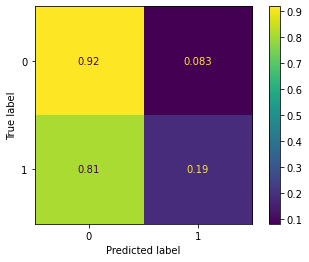

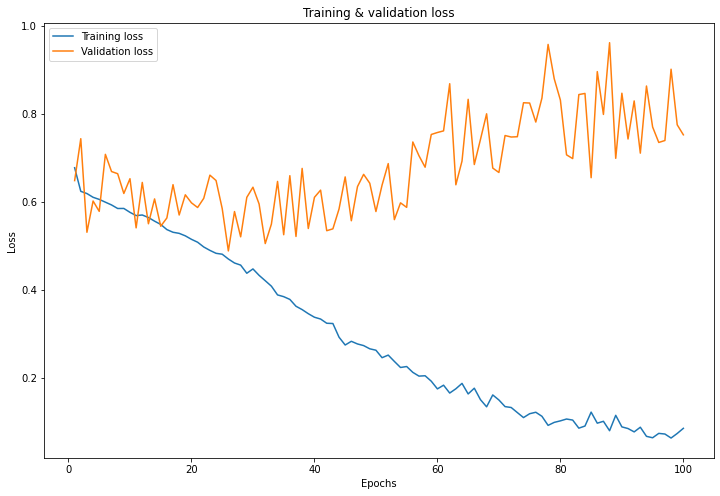

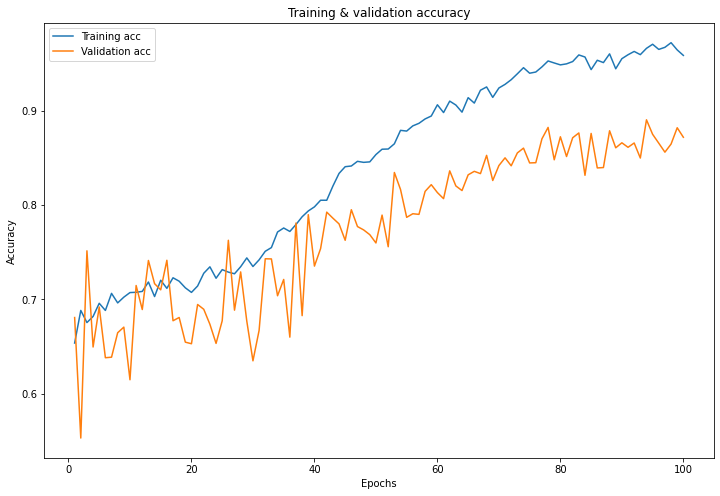

In [317]:
evaluate_model(dl_model_1_poly_3, preprocessed_poly3_val_data, valid_labels)
visualize_training_results(dl_model_1_poly_3_results)